In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/repos/YOLOv3/


/content/drive/MyDrive/repos/YOLOv3


In [ ]:
ls './'

checkpoints/  eval_yolov3.ipynb  log_df/             yolov3/
dataset@      log/               train_yolov3.ipynb


In [18]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
from yolov3.yolov3 import Create_Yolov3
#from yolov3.utils import load_yolo_weights, detect_image
#from yolov3.configs import *

#input_size = YOLO_INPUT_SIZE
#Darknet_weights = YOLO_DARKNET_WEIGHTS

#yolo = Create_Yolov3(input_size=input_size)
#load_yolo_weights(yolo, Darknet_weights) # use Darknet weight

import torch

In [ ]:
ls 'checkpoints/'

In [4]:
import colorsys
import random
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes


def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def draw_bbox(image, bboxes, CLASSES="./model_data/coco.names", show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors=''):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != ''else colors[class_ind]
        #bbox_thick = int(0.6 * (image_h + image_w) / 1000) / 15  
        bbox_thick = int(0.6 * (image_h + image_w) / 500)
        #if bbox_thick < 1: bbox_thick = 1
        #print(image_h, image_w, bbox_thick)
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            #score_str = f' {score:.2f}' if show_confidence else ''
            score_str = " {:.2f}".format(score) if show_confidence else "" 
            #label = f'{NUM_CLASS[class_ind]}' + score_str
            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names


In [5]:
def bbox_niou(boxes1, boxes2):
    #print("compute bbox_iou")
    # box [x, y, w, h], x,y: center of box
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]
    
    #[, 4]
    global Pred_xywh, Label_xywh, BOX1, BOX2
    Pred_xywh = boxes1
    Label_xywh = boxes2

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1) 

    # output 
    BOX1 = boxes1
    BOX2 = boxes2
    print('boxes1',  boxes1.shape)
    print('boxes2', boxes2.shape)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    iou = 1.0 * inter_area / union_area
    # add N_corner term
    # boxes2 contains boxes1 
    idx_4corners_2in1 = ( boxes1[..., 0] > boxes2[..., 0] ) & ( boxes1[..., 3] < boxes2[..., 3] ) \
                & ( boxes1[..., 1] > boxes2[..., 1]) & ( boxes1[..., 2] < boxes2[..., 2] )

    print("compute niou")
    #return 1.0 * inter_area / union_area
    #return iou + tf.cast( idx_4corners_2in1, tf.float32 )
    # change iou value to 1 if label contains pred
    idx_float = tf.cast( idx_4corners_2in1, tf.float32 )
    niou = iou * ( 1 - idx_float ) + idx_float
    return niou


In [6]:
def fits_to_uint8(fitsarr, vmin=-1, vmax=1,):
    
    # clip
    data = np.clip(fitsarr, vmin, vmax)
    # scale to [0,1]
    data = (data - vmin) / (vmax - vmin)
    # convert to uint8
    data = (255 * data).astype(np.uint8)
    # invert y axis
    #data = data[::-1, :]
    return data

def detect_(yolo, image_path = "./star/0.jpg", score_th=0.5, iou_nms=0.45, 
            showimg=False, readfits=False, clipfits=False, clipvmax=10, normfits=True, range01=True, showclassid=None):
    
    if readfits:
        fitspath = image_path.replace("jpg", "fits.npz")
        image_data = np.load(fitspath)["fitsarr"]
        if clipfits:
            image_data = np.clip(image_data, a_min=-clipvmax, a_max=clipvmax)
        if normfits:
            image_data = (image_data - image_data.mean() ) / image_data.std()

        if range01:
            image_data = (image_data + clipvmax) / (clipvmax * 2) # change range to [0, 1]

        #print("detect "fitspath)
        original_image = fits_to_uint8(image_data, vmin=-1, vmax=1)
        
    else:
        original_image      = cv2.imread(image_path)
        #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)    
        image_data = image_preprocess(np.copy(original_image), [input_size, input_size])

    image_data = tf.expand_dims(image_data, 0)
    
    pred_bbox = yolo.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
        
    #bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold=score_th)
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold=score_th)
    bboxes = nms(bboxes, iou_threshold=iou_nms, method='nms')
    if showclassid!=None:
        stacked_bboxes = np.stack(bboxes, axis=0)
    
        # draw only bboxes of classid 
        bboxes = stacked_bboxes [stacked_bboxes[:, 5] == showclassid, :]
    
    image = draw_bbox(original_image, bboxes, CLASSES=TRAIN_CLASSES, 
                      Text_colors=(255,0,0),
                      rectangle_colors=(128,255,0))
    
    if showimg:
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
    return np.array(bboxes)

In [7]:
def get_annot( annot_path = 'dataset/LEs920/train.txt'):
    """get annotation from dataset text"""
    with open(annot_path, 'r') as f:
        txt = f.readlines()
        annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
    resdic = {}
    for ann in annotations:
        ann = ann.split(' ')
        image_path = ann[0]
        boxarr = []
        for a in ann[1:]:
            box = np.fromstring(a, sep=',')
            boxarr.append(box)
        boxarr = np.array(boxarr)
        resdic[image_path] = boxarr

    return resdic


#### plot predicted bbox




In [ ]:
#anntxt = "./dataset/LEs576/train.txt"
#anntxt = "dataset/LEs576aug/train_aug1_s.txt"
#anntxt = "dataset/LEs576_new/tiles/train_augs.txt"
anntxt = "dataset/LEs576_new/tiles/test_augs.txt"

anndic = get_annot(anntxt)
imgfiles = list( anndic.keys() )

In [ ]:
train_imgs = [os.path.basename(i) for i in imgfiles]

In [ ]:
imgfiles

In [ ]:
import glob

tileslist = glob.glob( './dataset/LEs576/tiles/*.jpg' )
tileslist.sort()

In [ ]:
tileslist

In [ ]:
#bboxes_pred = detect_(yolo, image_path='./dataset/LEs576aug/tiles/.jpg', readfits=True,
#                score_th=0.5, iou_nms=0.5, showimg=True)
bboxes_list = []
for imgfile in tileslist:
    bboxes_pred = detect_(yolo, image_path=imgfile, readfits=True, showclassid=None,
                score_th=0.2, iou_nms=0.5, showimg=False)
    
    bboxes_list.append(bboxes_pred)

In [ ]:
tileslist[0:9]

['./dataset/LEs576/tiles/001_0.jpg',
 './dataset/LEs576/tiles/001_1.jpg',
 './dataset/LEs576/tiles/001_2.jpg',
 './dataset/LEs576/tiles/001_3.jpg',
 './dataset/LEs576/tiles/001_4.jpg',
 './dataset/LEs576/tiles/001_5.jpg',
 './dataset/LEs576/tiles/001_6.jpg',
 './dataset/LEs576/tiles/001_7.jpg',
 './dataset/LEs576/tiles/001_8.jpg']

In [ ]:
image_path

'./dataset/LEs576/tiles/001_8.jpg'

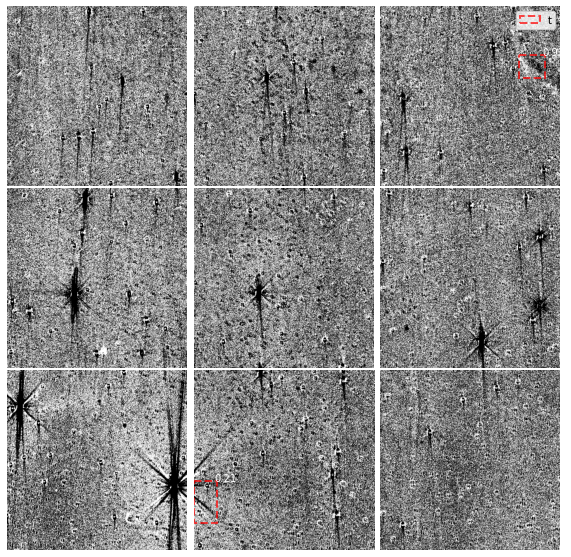

In [ ]:
imgid = 8
l = int( (imgid-1)*9)
r = int(l+9)
imgtiles = tileslist[l:r]
box_tiles = bboxes_list[l:r]

showclass = 0

fig, axs = plt.subplots(3, 3, figsize=(10, 10), 
                        gridspec_kw={'wspace':0.01, 'hspace':0.01}, )
axs = axs.flatten()

for i, image_path in enumerate(imgtiles):
    ax = axs[i]
    #ax.imshow(imgtile)
    ax.axis('off')
    ax.set_title(i)
    fitspath = image_path.replace("jpg", "fits.npz")
    image_data = np.load(fitspath)["fitsarr"]
    rgb_img = fits_to_uint8(image_data, vmin=-1, vmax=1)
    
    bboxes = box_tiles[i]
    if len(bboxes)!=0:
        if showclass!=None:
            #stacked_bboxes = np.stack(bboxes, axis=0)

            # draw only bboxes of classid 
            bboxes = bboxes [bboxes[:, 5] == showclass, :]
            labels = bboxes[:, 4]
        else:
            labels = bboxes[:, 5]
    
    plot_bboxes(img=rgb_img, bboxes=bboxes, labels=labels, ax=ax)
    if os.path.basename(image_path) in train_imgs:
        ax.legend("t" )

fig.savefig('./dataset/pred/{}.jpg'.format(imgid) )

In [ ]:
bboxes_pred

array([[298.72958374, 368.57147217, 482.48977661, 402.42077637,
          0.8500489 ,   0.        ]])

#### get df_pred

In [8]:
def switchxy(boxes):
    """switch the coord of bounding boxes
    bboxes: array, shape [N, 4]
    """
    boxes_new = np.zeros( boxes.shape )
    boxes_new[:, 0],  boxes_new[:, 1]= boxes[:, 1], boxes[:, 0]
    boxes_new[:, 2],  boxes_new[:, 3]= boxes[:, 3], boxes[:, 2]

    return boxes_new

In [9]:
def get_iou(box1, box2):
    """ calculate intersection over union"""
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(yi2-yi1, 0) * max(xi2-xi1, 0)
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[3] - box1[1]) *  (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) *  (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###
    
    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area / union_area
    ### END CODE HERE ###
    
    return iou

In [10]:
def get_giou(boxp, boxg, output='niou'):
    """ calculate generalized intersection over union
        boxp: predicted boxes
        boxg: groundtruth boxex
    """

    xp1, yp1, xp2, yp2 = boxp[0], boxp[1], boxp[2], boxp[3]
    xg1, yg1, xg2, yg2 = boxg[0], boxg[1], boxg[2], boxg[3]

    # calculate intersection
    xi1 = max(boxp[0], boxg[0])
    yi1 = max(boxp[1], boxg[1])
    xi2 = min(boxp[2], boxg[2])
    yi2 = min(boxp[3], boxg[3])
    inter_area = max(yi2-yi1, 0) * max(xi2-xi1, 0)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    boxp_area = (boxp[3] - boxp[1]) *  (boxp[2] - boxp[0])
    boxg_area = (boxg[3] - boxg[1]) *  (boxg[2] - boxg[0])
    union_area = boxp_area + boxg_area - inter_area
    
    # finding the coordinate of smallest enclosing box
    xc1 = min(xp1, xg1)
    yc1 = min(yp1, yg1)
    xc2 = max(xp2, xg2)
    yc2 = max(yp2, yg2)
    
    # calculate area of enclosing box
    closing_area = (xc2 - xc1) * (yc2 - yc1)
    
    # compute the IoU gIoU
    iou = inter_area / union_area

    giou = iou - (closing_area - union_area) / closing_area

    # if boxp inside boxg
    boxes1 = boxp
    boxes2 = boxg
    idx_4corners_1in2 = ( boxes1[..., 0] > boxes2[..., 0] ) & ( boxes1[..., 3] < boxes2[..., 3] ) \
                & ( boxes1[..., 1] > boxes2[..., 1]) & ( boxes1[..., 2] < boxes2[..., 2] )
    niou = iou
    if idx_4corners_1in2:
        niou = 1

    if output=='iou':
        return iou
    elif output=='niou':
        #print('use niou')
        return niou
    elif output=='iop':
        return inter_area / boxp_area
    else:
        return giou



In [141]:
def bbox_iou_torch(box1, box2, x1y1x2y2=True, GIoU=False, DIoU=False, CIoU=False, mIoU=False, IoP=False, eps=1e-7):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    # bbox_iou(pred, target)
    
    box1 = box1.T
    box2 = box2.T

    # Get the coordinates of bounding boxes
    if x1y1x2y2:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    else:  # transform from xywh to xyxy
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    union = w1 * h1 + w2 * h2 - inter + eps

    #print(inter, union)
    #print('box1 shape', box1.shape, 'inter shape', inter.shape, )
    #print("compute IoU")
    iou = inter / union

    # -------------------------------
    # modified iou
    # if boxp inside boxg
    # boxes1 = boxp
    # boxes2 = boxg
    
    if mIoU:
        #print("compute mIoU")
        boxes1 = box1.T
        boxes2 = box2.T
        idx_4corners_1in2 = ( boxes1[..., 0] >= boxes2[..., 0] ) & ( boxes1[..., 3] <= boxes2[..., 3] ) \
                    & ( boxes1[..., 1] >= boxes2[..., 1]) & ( boxes1[..., 2] <= boxes2[..., 2] )
        #print(idx_4corners_1in2)
        #niou = iou
        iou[ idx_4corners_1in2] = 1
        #if idx_4corners_1in2:
        #  niou = 1
        
    if IoP:
        #print("compute IoP")
        iou = inter / (w1*h1)

    # -------------------------------

    if CIoU or DIoU or GIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 +
                    (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center distance squared
            if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47

                
                v = (4 / np.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                print("compute CIoU")
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            #print("compute DIoU")
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        #print("compute GIoU")
        return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    
    return iou  # IoU


In [59]:
def get_df_pred(yolo, imgfiles, readfits=True, clipfits=True, clipvmax=10, normfits=True, range01=False):
    """get predicted boxes for each file"""
    df_pred = pd.DataFrame(columns=['imgid', 'img', 'classid',
                                     'boxes_ann', 'label_ann', 
                                     'boxes_pred', 'label_pred', 'score_pred'])

    classids = [0, 1]
    for imgid, image_path in enumerate( imgfiles ):
        # get labeled boxes
        ann = anndic[image_path]
        boxes_ann = ann[:, :4]
        label_ann = ann[:, 4]
        #print(imgid, image_path)
        pred = detect_(yolo, image_path=image_path, readfits=readfits, clipfits=clipfits, 
                                clipvmax=clipvmax, normfits=normfits, range01=range01,
                            score_th=0.0001, iou_nms=0.1, showimg=False)
        # pred for one img
        boxes_pred = pred[:, :4]
        score_pred = pred[:, 4]
        label_pred = pred[:, 5]

        for classid in classids:
            # prediction for one class
            cls_idx = label_pred == classid
            boxes_pred_cls = pred[:, :4] [cls_idx]
            score_pred_cls = pred[:, 4] [cls_idx]
            label_pred_cls = pred[:, 5] [cls_idx]
            
            # annotation for one class
            boxes_ann_cls = boxes_ann[label_ann==classid]
            label_ann_cls = label_ann[label_ann==classid]

            row = {'imgid':imgid, 'img': image_path, 'classid':classid,
                    'boxes_ann':boxes_ann_cls , 'label_ann': label_ann_cls, 
                    'boxes_pred':boxes_pred_cls, 'label_pred':label_pred_cls, 'score_pred':score_pred_cls}
            df_pred.loc[len(df_pred.index)] = row
    return df_pred


In [165]:
def get_mat_iou_torch(df_pred, **kwargs):
    """ get the iou matrix between predicted and annotated box """

    boxp = df_pred['boxes_pred']
    boxa = df_pred['boxes_ann']
    
    boxa = torch.from_numpy(boxa, )

    # axis=0 pred; axis=1 ann
    gious = []  

    for bp in boxp:
        bp = torch.from_numpy(bp, )
        giou = bbox_iou_torch(bp, boxa, **kwargs) # giou(prediction, target)
        gious.append( giou.numpy()  )
    
    return np.array( gious )




In [60]:
def get_mat_iou(df_pred):
    """get the iou matrix between predicted and annotated box"""
    boxp = df_pred['boxes_pred']
    boxa = df_pred['boxes_ann']
    #  axis=0 pred; axis=1 ann
    matshape = ( boxp.shape[0], boxa.shape[0] )

    mat_iou = np.zeros( matshape )
    
    for i in range( matshape[0] ):
        for j in range( matshape[1] ):
            mat_iou[i, j] = get_giou(boxp=boxp[i], boxg=boxa[j], output='iou')
    return mat_iou

def get_mat_niou(df_pred):
    """get the iou matrix between predicted and annotated box"""
    boxp = df_pred['boxes_pred']
    boxa = df_pred['boxes_ann']
    #  axis=0 pred; axis=1 ann
    matshape = ( boxp.shape[0], boxa.shape[0] )

    mat_iou = np.zeros( matshape )
    
    for i in range( matshape[0] ):
        for j in range( matshape[1] ):
            mat_iou[i, j] = get_giou(boxp=boxp[i], boxg=boxa[j], output='niou')
    return mat_iou

def get_mat_iop(df_pred):
    """get the iou matrix between predicted and annotated box"""
    boxp = df_pred['boxes_pred']
    boxa = df_pred['boxes_ann']
    #  axis=0 pred; axis=1 ann
    matshape = ( boxp.shape[0], boxa.shape[0] )

    mat_iou = np.zeros( matshape )
    
    for i in range( matshape[0] ):
        for j in range( matshape[1] ):
            mat_iou[i, j] = get_giou(boxp=boxp[i], boxg=boxa[j], output='iop')
    return mat_iou



In [61]:
def get_iou_pred(df_pred):
    """get the max iou for each predicted box"""
    if df_pred['mat_iou'].shape[1]==0:
        ious = np.zeros( df_pred['mat_iou'].shape[0] )
    else:
        ious = np.max( df_pred['mat_iou'], axis=1)
    return ious

def get_objid_pred(df_pred):
    """get the object id for each predicted box"""
    if df_pred['mat_iou'].shape[1]==0:
        ious = np.zeros( df_pred['mat_iou'].shape[0] )
        objids = ious
        objids[ ious==0 ] = -1  # change to -1 if max iou =0
    else:
        ious = np.max( df_pred['mat_iou'], axis=1)
        objids = np.argmax( df_pred['mat_iou'], axis=1)
        objids = df_pred['imgid'] * 100 + objids
        objids[ ious==0 ] = -1  # change to -1 if max iou =0
    return objids

def get_iou_ann(df_pred):
    """get the max iou for each annotated box"""
    if 0 in df_pred['mat_iou'].shape:
        ious = np.array([])
    else:
        ious = np.max( df_pred['mat_iou'], axis=0)
    return ious

def get_score_ann(df_pred):
    """get the score for each annotated box"""
    if 0 in df_pred['mat_iou'].shape:
        score_ann = np.array([])
    else:
        ious = np.max( df_pred['mat_iou'], axis=0)
        predboxid = np.argmax( df_pred['mat_iou'], axis=0)
        score_ann = df_pred['score_pred'][ predboxid ]
        score_ann [ ious==0 ] = -1
    return score_ann


In [62]:
# get nTP
def get_nAnn(df_pred):
    """get number of Ann box"""
    nAnn = len( df_pred["label_ann"] )
    return nAnn

def get_nDet(df_pred, score_th=0.1):
    """get nDet for score > score_th"""
    nDet = np.sum( df_pred["score_pred"] > score_th )
    return nDet

def get_nTP_pred(df_pred, score_th=0.1, iou_th=0.1):
    
    ious_pred = df_pred['iou_pred']
    scores_pred = df_pred['score_pred']
    objids_pred = df_pred['objid_pred']

    ious_det_pred = ious_pred [ scores_pred > score_th ]
    #ious_det_ann = ious_ann [ scores_ann > score_th ]
    #objids_det = objids_pred[ scores_pred > score_th ]

    nTP_pred = np.sum( ious_det_pred > iou_th )
    return nTP_pred

def get_nTP_ann(df_pred, score_th=0.1, iou_th=0.1):
    
    ious_pred = df_pred['iou_pred']
    scores_pred = df_pred['score_pred']
    objids_pred = df_pred['objid_pred']

    ious_det_pred = ious_pred [ scores_pred > score_th ]
    #ious_det_ann = ious_ann [ scores_ann > score_th ]
    objids_det = objids_pred[ scores_pred > score_th ]

    #nTP_pred = np.sum( ious_det_pred > iou_th )
    objids_TP = objids_det[ ious_det_pred > iou_th ]
    #nTP_ann = np.sum( ious_det_ann > iou_th )
    nTP_ann = len( np.unique(objids_TP[objids_TP!=-1] ) )
    return nTP_ann


In [ ]:
ls 'log_df'

In [64]:
input_size = 576
TRAIN_CLASSES  = "dataset/LE_cand1/LEs_name.txt"
yolo = Create_Yolov3(input_size=input_size, CLASSES=TRAIN_CLASSES)

#anndic = get_annot("dataset/LE_cand1/test_aug.txt")

anndic = get_annot("dataset/LE_cand1_largebox/test_aug3.txt")

#anndic = get_annot("dataset/LE_cand1/test_aug_addstar.txt")

imgfiles = list( anndic.keys() )


In [22]:
len(imgfiles)

72

In [ ]:
for epoch in range(2, 101, 2): print(epoch)

In [ ]:
%%time
#for modelname in  ['model_miou_v1', 'model_niou_v2','model_iou_v3']:
#for modelname in  ['model_iou_v2', 'model_miou_v3']:

#modelname = 'model_miou_v1'
#modelname = 'model_miou_v4'
# epoch = 50
for modelname in [ 'model_miou_train_aug2_range01', 'model_miou_train_aug3_range01', ]: #'model_iou_v2', 
                   #'model_miou_v3' , 'model_miou_v4', 'model_iop_v5']:

    if 'aug2' in modelname:
        anndic = get_annot("dataset/LE_cand1_largebox/test_aug2.txt")
        imgfiles = list( anndic.keys() )

    if 'aug3' in modelname:
        anndic = get_annot("dataset/LE_cand1_largebox/test_aug3.txt")
        imgfiles = list( anndic.keys() )

    for epoch in range(1, 101, 2):
        weights = "{}_ep{}".format( modelname, epoch)
        print("load weights ", weights)
        
        yolo.load_weights(f"./checkpoints/{weights}")
        
        #print("getting df_pred... ")
        #if 'v3' in modelname:
        #    df_pred = get_df_pred(yolo, imgfiles, clipvmax=1, normfits=True)
        #elif 'v4' in modelname:
        #    df_pred = get_df_pred(yolo, imgfiles, clipvmax=10, normfits=False)
        #elif 'v2' in modelname:
        #    df_pred = get_df_pred(yolo, imgfiles, clipvmax=10, normfits=False, range01=True)
        #    print('scale to [0, 1]')
        #else:
        df_pred = get_df_pred(yolo, imgfiles, clipvmax=10, normfits=False, range01=True)
        
        #df_pred_iou = df_pred.copy()
        df_pred_iop = df_pred.copy()
        
        print("computing iou...")
        df_pred['mat_iou'] = df_pred.apply(get_mat_niou, axis=1)
        #df_pred_iou['mat_iou'] = df_pred_iou.apply(get_mat_iou, axis=1)
        df_pred_iop['mat_iou'] = df_pred_iop.apply(get_mat_iop, axis=1)
        
        #for df in [df_pred, df_pred_iou, df_pred_iop]:
        for df in [df_pred, df_pred_iop]:
        
            df['iou_pred'] = df.apply(get_iou_pred , axis=1)
            df['objid_pred'] = df.apply(get_objid_pred , axis=1)
            df['iou_ann'] = df.apply(get_iou_ann , axis=1)
            df['score_ann'] = df.apply(get_score_ann , axis=1)
        
            # Ann
            df['nAnn'] = df.apply(get_nAnn, axis=1)
            df['nDet_s0.2'] = df.apply(get_nDet, args=(0.2,), axis=1, )
            df['nTP_pred_s0.2_i0.1'] = df.apply(get_nTP_pred, args=(0.2, 0.1), axis=1, )
            df['nTP_ann_s0.2_i0.1'] = df.apply(get_nTP_ann, args=(0.2, 0.1), axis=1, )
        
        print(f"{epoch} save to pickle")
        df_pred.to_pickle(f"./log_df/df_pred_miou_{weights}_testset_largebox.pickle")
        #df_pred_iou.to_pickle(f"./log_df/df_pred_iou_{weights}_testset_largebox.pickle")
        df_pred_iop.to_pickle(f"./log_df/df_pred_iop_{weights}_testset_largebox.pickle")


load weights  model_miou_train_aug2_range01_ep1
computing iou...
1 save to pickle
load weights  model_miou_train_aug2_range01_ep3
computing iou...
3 save to pickle
load weights  model_miou_train_aug2_range01_ep5
computing iou...
5 save to pickle
load weights  model_miou_train_aug2_range01_ep7
computing iou...
7 save to pickle
load weights  model_miou_train_aug2_range01_ep9
computing iou...
9 save to pickle
load weights  model_miou_train_aug2_range01_ep11
computing iou...
11 save to pickle
load weights  model_miou_train_aug2_range01_ep13
computing iou...
13 save to pickle
load weights  model_miou_train_aug2_range01_ep15
computing iou...
15 save to pickle
load weights  model_miou_train_aug2_range01_ep17
computing iou...
17 save to pickle
load weights  model_miou_train_aug2_range01_ep19
computing iou...
19 save to pickle
load weights  model_miou_train_aug2_range01_ep21
computing iou...
21 save to pickle
load weights  model_miou_train_aug2_range01_ep23
computing iou...
23 save to pickle
lo

NotFoundError: ignored

In [ ]:
%%time
#for modelname in  ['model_miou_v1', 'model_niou_v2','model_iou_v3']:
#for modelname in  ['model_iou_v2', 'model_miou_v3']:
for modelname in  [ 'model_miou_v1']:
    for epoch in range(1, 100, 1):
        weights = "{}_ep{}".format( modelname, epoch)
        print("load weights ", weights)

        yolo.load_weights(f"./checkpoints/{weights}")

        print("getting df_pred... ")
        #if 'v3' in modelname:
        #    df_pred = get_df_pred(yolo, imgfiles, clipvmax=1, normfits=True)
        #elif 'v4' in modelname:
        #    df_pred = get_df_pred(yolo, imgfiles, clipvmax=10, normfits=False)
        #else:
        df_pred = get_df_pred(yolo, imgfiles, clipvmax=10, normfits=True)

        df_pred_iou = df_pred.copy()
        print("computing iou...")
        df_pred['mat_iou'] = df_pred.apply(get_mat_niou, axis=1)
        df_pred_iou['mat_iou'] = df_pred_iou.apply(get_mat_iou, axis=1)

        for df in [df_pred, df_pred_iou]:

            df['iou_pred'] = df.apply(get_iou_pred , axis=1)
            df['objid_pred'] = df.apply(get_objid_pred , axis=1)
            df['iou_ann'] = df.apply(get_iou_ann , axis=1)
            df['score_ann'] = df.apply(get_score_ann , axis=1)

            # Ann
            df['nAnn'] = df.apply(get_nAnn, axis=1)
            df['nDet_s0.2'] = df.apply(get_nDet, args=(0.2,), axis=1, )
            df['nTP_pred_s0.2_i0.1'] = df.apply(get_nTP_pred, args=(0.2, 0.1), axis=1, )
            df['nTP_ann_s0.2_i0.1'] = df.apply(get_nTP_ann, args=(0.2, 0.1), axis=1, )

        print("save to pickle")
        df_pred.to_pickle(f"./log_df/df_pred_miou_{weights}.pickle")
        df_pred_iou.to_pickle(f"./log_df/df_pred_iou_{weights}.pickle")



load weights  model_iop_v5_ep50
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep51
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep52
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep53
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep54
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep55
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep56
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep57
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep58
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep59
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep60
getting df_pred... 
computing iou...
save to pickle
load weights  model_iop_v5_ep61
getting df_pred... 
computing iou...
save to

In [ ]:
ls ./log_df/

In [ ]:
%%time
# calculate iop from pickle df_pred
#for modelname in  ['model_miou_v1', 'model_niou_v2','model_iou_v3']:
#for modelname in  ['model_miou_v1', 'model_iou_v2', 'model_miou_v3']:

for modelname in ['model_miou_v4', 'model_iop_v5']:

    for epoch in range(0, 100, 1):
        weights = "{}_ep{}".format( modelname, epoch)
        print("load weights ", weights)

        df_pred = pd.read_pickle(f"./log_df/df_pred_miou_{weights}.pickle")

        df_pred_iop = df_pred.copy()
        print("computing iou...")
        #df_pred['mat_iou'] = df_pred.apply(get_mat_niou, axis=1)
        df_pred_iop['mat_iou'] = df_pred_iop.apply(get_mat_iop, axis=1)

        for df in [ df_pred_iop]:

            df['iou_pred'] = df.apply(get_iou_pred , axis=1)
            df['objid_pred'] = df.apply(get_objid_pred , axis=1)
            df['iou_ann'] = df.apply(get_iou_ann , axis=1)
            df['score_ann'] = df.apply(get_score_ann , axis=1)

            # Ann
            df['nAnn'] = df.apply(get_nAnn, axis=1)
            df['nDet_s0.2'] = df.apply(get_nDet, args=(0.2,), axis=1, )
            df['nTP_pred_s0.2_i0.1'] = df.apply(get_nTP_pred, args=(0.2, 0.1), axis=1, )
            df['nTP_ann_s0.2_i0.1'] = df.apply(get_nTP_ann, args=(0.2, 0.1), axis=1, )

        print("save to pickle")
        df_pred_iop.to_pickle(f"./log_df/df_pred_iop_{weights}.pickle")



load weights  model_miou_v4_ep0
computing iou...
save to pickle
load weights  model_miou_v4_ep1
computing iou...
save to pickle
load weights  model_miou_v4_ep2
computing iou...
save to pickle
load weights  model_miou_v4_ep3
computing iou...
save to pickle
load weights  model_miou_v4_ep4
computing iou...
save to pickle
load weights  model_miou_v4_ep5
computing iou...
save to pickle
load weights  model_miou_v4_ep6
computing iou...
save to pickle
load weights  model_miou_v4_ep7
computing iou...
save to pickle
load weights  model_miou_v4_ep8
computing iou...
save to pickle
load weights  model_miou_v4_ep9
computing iou...
save to pickle
load weights  model_miou_v4_ep10
computing iou...
save to pickle
load weights  model_miou_v4_ep11
computing iou...
save to pickle
load weights  model_miou_v4_ep12
computing iou...
save to pickle
load weights  model_miou_v4_ep13
computing iou...
save to pickle
load weights  model_miou_v4_ep14
computing iou...
save to pickle
load weights  model_miou_v4_ep15
co

In [ ]:
%%time
for modelname in  ['model_miou_v1', 'model_niou_v2','model_iou_v3']:
    for epoch in range(0, 61, 5):
        weights = "{}_ep{}".format( modelname, epoch)

        df_pred = pd.read_pickle(f"./log_df/df_pred_miou_{weights}.pickle")
        df_pred_iou = pd.read_pickle(f"./log_df/df_pred_iou_{weights}.pickle")

        for df in [df_pred, df_pred_iou]:
            # Ann
            #df['nAnn'] = df.apply(get_nAnn, axis=1)
            df['nDet_s0.2'] = df.apply(get_nDet, args=(0.2,), axis=1, )
            df['nTP_pred_s0.2_i0.1'] = df.apply(get_nTP_pred, args=(0.2, 0.1), axis=1, )
            df['nTP_ann_s0.2_i0.1'] = df.apply(get_nTP_ann, args=(0.2, 0.1), axis=1, )

        print(f"save to pickle {weights}")
        df_pred.to_pickle(f"./log_df/df_pred_miou_{weights}.pickle")
        df_pred_iou.to_pickle(f"./log_df/df_pred_iou_{weights}.pickle")



In [ ]:
def plot_roc_pr_curve(df_pred, classid=0, saveto=None):
    """plot roc/pr curve """
    #df_pred = pd.read_pickle("./log_niou/df_pred_niou_v5_testset.pickle")

    fig, axs = plt.subplots(1, 3, figsize=(19, 5))
    axs = axs.flatten()

    #IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]
    
    IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5,]

    SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]
    cls_idx = df_pred['classid']==classid
    scores_pred = np.concatenate( df_pred[cls_idx] ['score_pred'].values )
    ious_pred = np.concatenate( df_pred[cls_idx]['iou_pred'].values )
    ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
    #scores_ann = np.concatenate( df_pred[cls_idx]['score_ann'].values )
    objids_pred = np.concatenate(df_pred[cls_idx]['objid_pred'].values)
    nAnn = len(ious_ann)
    ax = axs[0]

    ax.scatter(scores_pred[ious_pred==0], ious_pred[ious_pred==0], 
               facecolor='none', edgecolor=colors[0], s=15, alpha=0.5, label='')
    ax.scatter(scores_pred[ious_pred!=0], ious_pred[ious_pred!=0], 
               facecolor=colors[0], s=15, alpha=0.5, label='')
    #ax.scatter(scores_ann, ious_ann, s=10, alpha=0.8, )
    ax.plot(np.linspace(0, 1, 10), 0.1*np.ones(10), 'k' , linewidth=0.5)
    ax.plot(0.1*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)
    ax.set_xlabel("score")
    ax.set_ylabel("iou")

    ax1 = axs[1]
    ax2 = axs[2]

    x = np.linspace(0, 800, 10)
    ax1.plot(x, x , 'k-', label=' TP/FP = 1', )
    ax1.plot(x, 1/5 *x , 'k--', label=' TP/FP = 1/5', )
    ax1.plot(x, 1/10 *x , 'k-.', label=' TP/FP = 1/10', )

    for i, iou_th in enumerate(IOU_THs):
        nTPs = []
        nFPs = []
        precision = []
        recall = []
        for score_th in SCORE_THs:
            # idx_s = scores > score_th
            nDet = np.sum( scores_pred > score_th )
            ious_det_pred = ious_pred [ scores_pred > score_th ]
            #ious_det_ann = ious_ann [ scores_ann > score_th ]
            objids_det = objids_pred[ scores_pred > score_th ]

            nTP_pred = np.sum( ious_det_pred > iou_th )
            objids_TP = objids_det[ ious_det_pred > iou_th ]
            #nTP_ann = np.sum( ious_det_ann > iou_th )
            nTP_ann = len( np.unique(objids_TP[objids_TP!=-1] ) )
            #nTP = np.min([nTP_pred, nTP_ann])
            nFP = nDet - nTP_pred
            nTPs.append(nTP_ann)
            nFPs.append(nFP)

            p = nTP_pred/nDet
            r = nTP_ann/nAnn
            precision.append(p)
            recall.append(r)
            #print("iou_th:{},score_th:{}, nDet:{}, nTP:{}, nFP:{}".format(iou_th, score_th, nDet, nTP_ann, nFP))
            #ax1.text(nFP, nTP_ann, score_th)
            if iou_th==0:
                ax2.text(r, p, score_th)

        #print(iou_th, precision, recall )

        ax2.plot(recall, precision,'.-', label='iou>{}'.format(iou_th), color=colors[i] )
        nFPs = np.array(nFPs)
        nTPs = np.array(nTPs)
        ax1.plot(nFPs[nFPs>0], nTPs[nFPs>0], '.-', label='iou>{}'.format(iou_th), color=colors[i])

    #ax.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
    #ax.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )
    ax1.legend(['TP/FP=1','TP/FP=1/5','TP/FP=1/10'],loc='lower right')

    ax1.set_xlabel("FP")
    ax1.set_ylabel("TP")
    ax1.set_xlim([0, 800])
    ax1.set_ylim([0, nAnn])
    #ax1.set_xscale('log')

    ax2.set_xlabel("recall")
    ax2.set_ylabel("precision")
    ax2.set_xlim([0, 1.1])
    ax2.set_ylim([0, 1.1])
    plt.legend(loc='lower left')

    if saveto!=None:
        fig.savefig(fname=saveto)



In [ ]:
thecbases = [plt.cm.Blues,
             plt.cm.Greens,
             plt.cm.Purples,
             plt.cm.Reds,
             plt.cm.YlOrBr,
             (240./255,230./255,140./255, 1.),
            ]
grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]

#thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
#                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
#                     for i in range(5)] + [thecbases[5]]}

thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
            'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
pairs = 'same'
colors = np.vstack( [c for c in thecmaps[pairs]] )


In [ ]:
modelname = "model_miou_v1"  #['model_miou_v1', 'model_niou_v2','model_iou_v3'
clsid = 0
epoch = 50
weights = "{}_ep{}".format( modelname, epoch)

df_pred = pd.read_pickle(f"./log_df/df_pred_miou_{weights}.pickle")

nAnn = df_pred[df_pred.classid==clsid]["nAnn"].sum()

nDet = df_pred[df_pred.classid==clsid]["nDet_s0.2"].sum()

nTP_pred = df_pred[df_pred.classid==clsid]["nTP_pred_s0.1_i0.2"].sum()
nTP_ann = df_pred[df_pred.classid==clsid]["nTP_ann_s0.1_i0.2"].sum()

precision = nTP_pred /nDet
recall = nTP_ann / nAnn



In [ ]:
clsid = 0
modelname = "model_miou_v1" 

epochs = []
precisions = []
recalls = []
for epoch in range(0, 61, 5):
    weights = "{}_ep{}".format( modelname, epoch)

    df_pred = pd.read_pickle(f"./log_df/df_pred_miou_{weights}.pickle")

    nAnn = df_pred[df_pred.classid==clsid]["nAnn"].sum()

    nDet = df_pred[df_pred.classid==clsid]["nDet_s0.2"].sum()

    nTP_pred = df_pred[df_pred.classid==clsid]["nTP_pred_s0.2_i0.1"].sum()
    nTP_ann = df_pred[df_pred.classid==clsid]["nTP_ann_s0.2_i0.1"].sum()
    if nDet!=0:
        p = nTP_pred /nDet
        r = nTP_ann / nAnn
        print(f"epoch {epoch}, p {p}, r {r}, nAnn {nAnn}, nDet {nDet}")
        precisions.append(p)
        recalls.append(r)
        epochs.append(epoch)


epoch 0, p 0.024553379713132355, r 1.0, nAnn 144, nDet 186288
epoch 5, p 0.014664804469273743, r 0.1875, nAnn 144, nDet 2864
epoch 15, p 0.6933333333333334, r 0.4027777777777778, nAnn 144, nDet 150
epoch 20, p 0.5569620253164557, r 0.7361111111111112, nAnn 144, nDet 237
epoch 25, p 0.39072847682119205, r 0.6805555555555556, nAnn 144, nDet 302
epoch 30, p 0.4530612244897959, r 0.6736111111111112, nAnn 144, nDet 245
epoch 35, p 0.3413897280966767, r 0.6666666666666666, nAnn 144, nDet 331
epoch 40, p 0.3681159420289855, r 0.7569444444444444, nAnn 144, nDet 345
epoch 45, p 0.4473684210526316, r 0.8055555555555556, nAnn 144, nDet 304
epoch 50, p 0.49019607843137253, r 0.7430555555555556, nAnn 144, nDet 255
epoch 55, p 0.42033898305084744, r 0.7291666666666666, nAnn 144, nDet 295
epoch 60, p 0.44366197183098594, r 0.7291666666666666, nAnn 144, nDet 284


Text(0.5, 0, 'epoch')

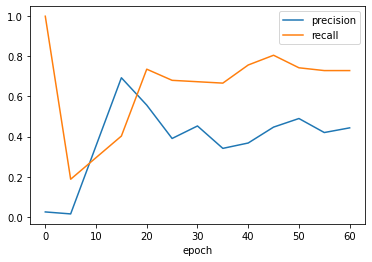

In [ ]:
plt.plot(epochs, precisions, label='precision')
plt.plot(epochs, recalls, label='recall')
plt.legend()
plt.xlabel("epoch")

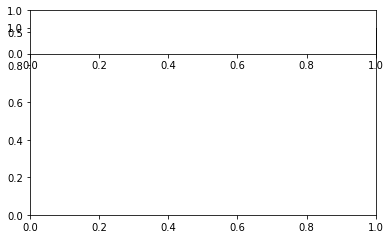

In [ ]:
fig =plt.figure()

ax1 = fig.add_axes((0.1, 0.1, 0.8, 0.65))
ax2 = fig.add_axes((0.1, 0.66, 0.8, 0.15))

In [ ]:
df_pred.head(2)

imgid  ... nTP_ann_s0.1_i0.2
0     0  ...                 0
1     0  ...                 7

[2 rows x 17 columns]

In [ ]:
modelname = "model_miou_v4"  #['model_miou_v1', 'model_niou_v2','model_iou_v3'
epoch = 40
weights = "{}_ep{}".format( modelname, epoch)

df_pred = pd.read_pickle(f"./log_df/df_pred_miou_{weights}.pickle")


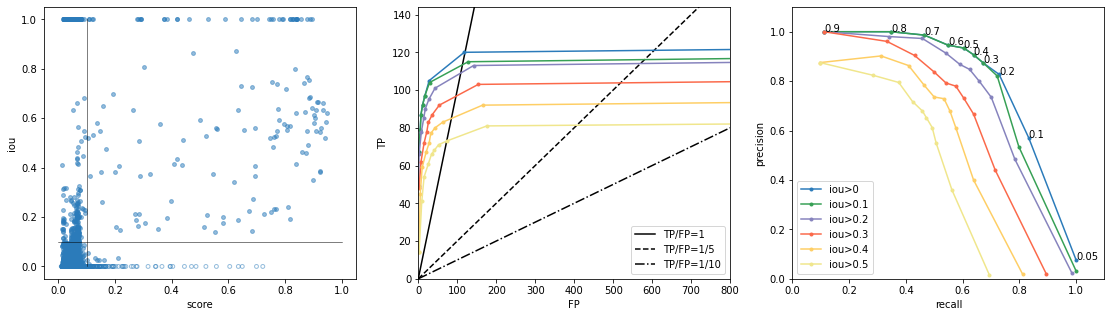

In [ ]:
plot_roc_pr_curve(df_pred, classid=0, saveto=None)

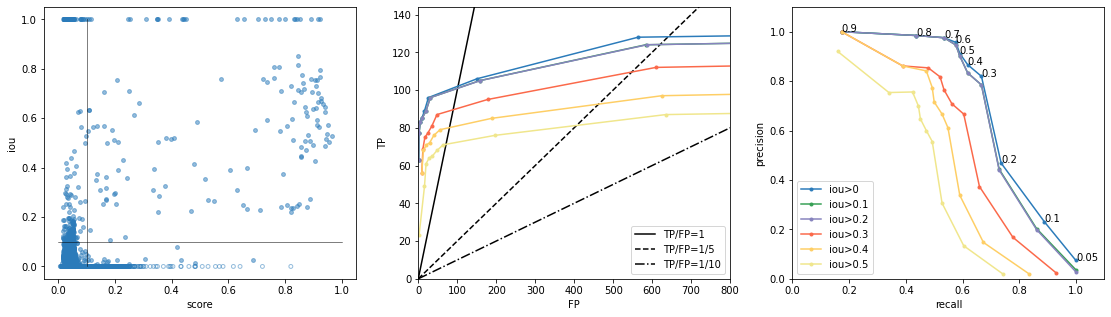

In [ ]:
modelname = "model_miou_v1"  #['model_miou_v1', 'model_niou_v2','model_iou_v3'
epoch = 60
weights = "{}_ep{}".format( modelname, epoch)

df_pred = pd.read_pickle(f"./log_df/df_pred_miou_{weights}.pickle")

plot_roc_pr_curve(df_pred, classid=0, saveto=None)

In [ ]:
30 / 156

0.19230769230769232

In [ ]:
def plot_iou_score(df_pred, idx, score_th=0.1, iou_th=0.3, axs=[]):
    """idx: img id
       axs """
    print(idx, df_pred['img'][idx])
    x = df_pred['score_pred'][idx]
    y = df_pred['iou_pred'][idx]
    c = df_pred['objid_pred'][idx]

    if len(axs)==0:
        fig, axs = plt.subplots(1, 3, figsize=(16, 5) )

    axs = axs.flatten()
    ax = axs[0]
    #ax.scatter(x, y, s=15, c=c, alpha=1, cmap=plt.cm.tab10)

    ax.scatter(x, y, s=15, alpha=0.5, facecolors='tab:blue', edgecolors='tab:blue')

    ax.plot(np.linspace(0, 1, 10), iou_th*np.ones(10), 'k' , linewidth=0.5)
    ax.plot(score_th*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)
    ax.set_xlabel("score")
    ax.set_ylabel("iou")
    #ax.set_title('imgid {}'.format(df_pred['imgid'][idx]))
    #ax.set_title('imgid {}'.format(df_pred['imgid'][idx]))

    ax = axs[1]
    #score_th = 0.1
    image_path = df_pred['img'][idx]
    scores = df_pred['score_pred'][idx]
    bboxes = df_pred['boxes_pred'][idx] [scores>score_th]
    labels = df_pred['score_pred'][idx] [scores>score_th]
    plot_bboxes(image_path=image_path, bboxes=bboxes, labels=[], ax=ax)
    ax.set_axis_off()
    ax.set_title('pred score>{}, nDet={}'.format(score_th, len(scores[scores>score_th])))

    #ax = axs[2]
    ##score_th = 0.1
    #image_path = df_pred['img'][idx]
    #ious = df_pred['iou_pred'][idx]
    #bboxes = df_pred['boxes_pred'][idx] [ (ious>iou_th)&(scores>score_th) ]
    #labels = df_pred['score_pred'][idx] [ (ious>iou_th)&(scores>score_th) ]
    #plot_bboxes(image_path=image_path, bboxes=bboxes, labels=labels, ax=ax)
    #ax.set_axis_off()
    #ax.set_title('pred score>{}, iou>{}, nTP={}'.format(score_th, iou_th, len(labels)))

    ax = axs[2]
    image_path = df_pred['img'][idx]
    bboxes = df_pred['boxes_ann'][idx] 
    labels = df_pred['score_ann'][idx]
    plot_bboxes(image_path=image_path, bboxes=bboxes, labels=[], ax=ax)
    ax.set_axis_off()
    ax.set_title(f'annotated nAnn = {len(labels)}')



In [ ]:
df_pred['img'] [ df_pred['img'].str.contains('007_0') ]

4             ./dataset/LE_cand1/tiles_aug/007_0_r90.jpg
5             ./dataset/LE_cand1/tiles_aug/007_0_r90.jpg
34                ./dataset/LE_cand1/tiles_aug/007_0.jpg
35                ./dataset/LE_cand1/tiles_aug/007_0.jpg
76           ./dataset/LE_cand1/tiles_aug/007_0_r180.jpg
77           ./dataset/LE_cand1/tiles_aug/007_0_r180.jpg
84     ./dataset/LE_cand1/tiles_aug/007_0_fliph_r180.jpg
85     ./dataset/LE_cand1/tiles_aug/007_0_fliph_r180.jpg
90      ./dataset/LE_cand1/tiles_aug/007_0_fliph_r90.jpg
91      ./dataset/LE_cand1/tiles_aug/007_0_fliph_r90.jpg
108         ./dataset/LE_cand1/tiles_aug/007_0_fliph.jpg
109         ./dataset/LE_cand1/tiles_aug/007_0_fliph.jpg
112          ./dataset/LE_cand1/tiles_aug/007_0_r270.jpg
113          ./dataset/LE_cand1/tiles_aug/007_0_r270.jpg
134    ./dataset/LE_cand1/tiles_aug/007_0_fliph_r270.jpg
135    ./dataset/LE_cand1/tiles_aug/007_0_fliph_r270.jpg
Name: img, dtype: object

In [ ]:
df_pred.iloc[4]['']

In [ ]:
while True:pass

34 ./dataset/LE_cand1/tiles_aug/007_0.jpg


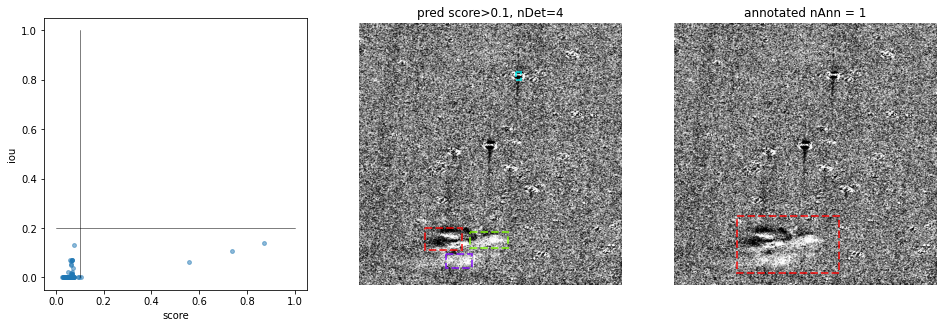

In [ ]:
plot_iou_score(df_pred, idx=34, score_th=0.1, iou_th=0.2, )


4 ./dataset/LE_cand1/tiles_aug/007_0_r90.jpg


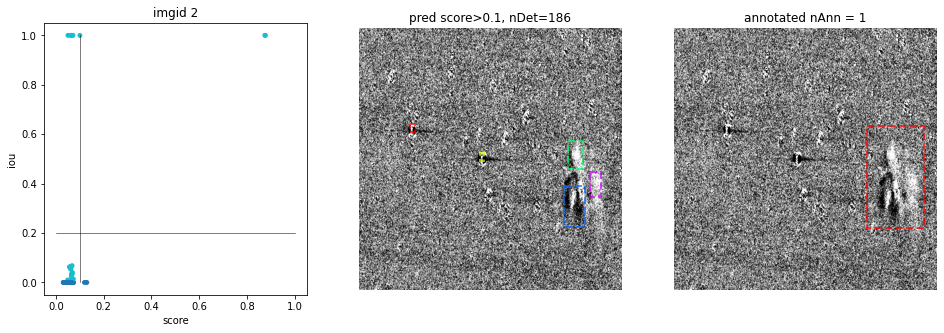

In [ ]:
plot_iou_score(df_pred, idx=4, score_th=0.1, iou_th=0.2, )


In [ ]:
'./dataset/LEs576aug/tiles_aug/013_8.jpg'.split('/')


['.', 'dataset', 'LEs576aug', 'tiles_aug', '013_8.jpg']

In [ ]:
idx = 0


'013_8.jpg'

In [ ]:
ls log_niou/

df_loss_niou_v1.csv                  df_pred_niou_v1_testset.jpg
df_loss_niou_v2.csv                  df_pred_niou_v2_testset_ep50.jpg
df_loss_val_niou_v1.csv              df_pred_niou_v2_testset_ep50.pickle
df_loss_val_niou_v2.csv              df_pred_niou_v2_testset.jpg
df_pred_niou_v1_testset_ep40.pickle  df_pred_niou_v3_testset.jpg
df_pred_niou_v1_testset_ep45.jpg     pred_v1/
df_pred_niou_v1_testset_ep50.jpg     pred_v1_old/
df_pred_niou_v1_testset_ep50.pickle  pred_v2/
df_pred_niou_v1_testset_ep55.jpg


0 ./dataset/LE_cand1/tiles_aug/008_5_r270.jpg
2 ./dataset/LE_cand1/tiles_aug/003_0_r270.jpg
4 ./dataset/LE_cand1/tiles_aug/007_0_r90.jpg
6 ./dataset/LE_cand1/tiles_aug/008_5_fliph_r270.jpg
8 ./dataset/LE_cand1/tiles_aug/012_2_fliph.jpg
10 ./dataset/LE_cand1/tiles_aug/014_1_fliph_r180.jpg
12 ./dataset/LE_cand1/tiles_aug/003_1_r180.jpg
14 ./dataset/LE_cand1/tiles_aug/014_1_fliph_r90.jpg
16 ./dataset/LE_cand1/tiles_aug/017_0.jpg
18 ./dataset/LE_cand1/tiles_aug/012_2_fliph_r90.jpg
20 ./dataset/LE_cand1/tiles_aug/003_0_fliph.jpg
22 ./dataset/LE_cand1/tiles_aug/017_0_r180.jpg
24 ./dataset/LE_cand1/tiles_aug/012_2_r90.jpg
26 ./dataset/LE_cand1/tiles_aug/008_5_r90.jpg
28 ./dataset/LE_cand1/tiles_aug/004_4_r180.jpg
30 ./dataset/LE_cand1/tiles_aug/014_1_fliph.jpg
32 ./dataset/LE_cand1/tiles_aug/004_4_r270.jpg
34 ./dataset/LE_cand1/tiles_aug/007_0.jpg
36 ./dataset/LE_cand1/tiles_aug/004_4_fliph_r180.jpg
38 ./dataset/LE_cand1/tiles_aug/003_1_fliph.jpg
40 ./dataset/LE_cand1/tiles_aug/012_2_r270.jpg

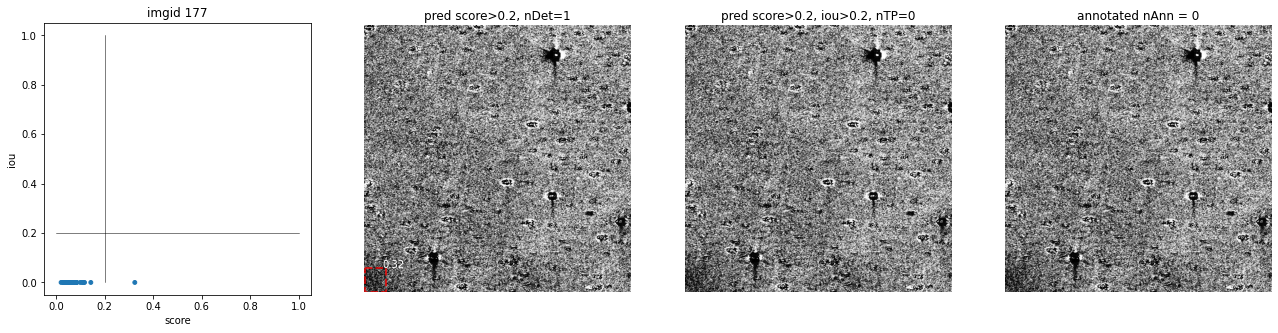

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5) )

sl = df_pred['img'].str.contains("none")
df_pred['img'][~sl]

idxes = df_pred['img'][~sl ].index.to_list()
for idx in idxes[::2]:
    df_pred['img'] 
    for ax in axs:
        ax.clear()
    plot_iou_score(df_pred, idx, score_th=0.2, iou_th=0.2, axs=axs)
    fig.savefig("./log_niou/pred_v2/{}".format( df_pred['img'][idx].split('/')[-1] ) )


In [ ]:
# missed 
df_pred_LE = df_pred[(df_pred['classid']==0) ].copy()
df_LE_missed = df_pred_LE[  (df_pred_LE['nTP_pred_s0.1_i0.2'] < df_pred_LE['nAnn']) ]
df_LE_missed.shape

(24, 17)

In [ ]:
df_LE_missed.iloc[1]

imgid                                                                 4
img                       ./dataset/LEs576aug/tiles_aug/012_4_fliph.jpg
classid                                                               0
boxes_ann             [[401.0, 240.0, 505.0, 291.0], [102.0, 0.0, 20...
label_ann                                                    [0.0, 0.0]
boxes_pred            [[258.4270324707031, 217.5694580078125, 331.73...
label_pred            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
score_pred            [0.1434141993522644, 0.11195488274097443, 0.10...
mat_iou               [[0.0, 0.0], [0.0, 0.0], [0.31068505295643845,...
iou_pred              [0.0, 0.0, 0.31068505295643845, 0.0, 0.0, 0.0,...
objid_pred            [-1, -1, 400, -1, -1, -1, -1, -1, -1, -1, -1, ...
iou_ann                       [0.31068505295643845, 0.4021799634055835]
score_ann                   [0.10866130143404007, 0.053066909313201904]
nAnn                                                            

In [ ]:
df_LE_missed

In [ ]:
df['nAnn'].sum(), df['nTP_ann_s0.1_i0.2'].sum()

(53, 29)

In [ ]:
ls 'log_niou'

df_loss_niou_v2.csv             df_pred_niou_v2_testset.pickle
df_loss_niou_v3.csv             df_pred_niou_v3_testset.jpg
df_loss_niou_v4.csv             df_pred_niou_v3_testset.pickle
df_loss_niou_v5.csv             df_pred_niou_v4_testset.pickle
df_loss_niou_v6.csv             df_pred_niou_v5_testset.pickle
df_loss_val_niou_v2.csv         df_pred_niou_v6_testset.pickle
df_loss_val_niou_v3.csv         pred/
df_loss_val_niou_v4.csv         pred_v3/
df_loss_val_niou_v5.csv         pred_v3_missed_LE/
df_loss_val_niou_v6.csv         pred_v6/
df_pred_niou_testset.pickle     pred_v6_missed_LE/
df_pred_niou_v1_testset.pickle


In [ ]:
ls "./log_niou/pred_v6_pred_v6_missed_LE/'

0 ./dataset/LEs576aug/tiles_aug/012_4_fliph.jpg
1 ./dataset/LEs576aug/tiles_aug/005_0_r180.jpg
2 ./dataset/LEs576aug/tiles_aug/002_0.jpg
3 ./dataset/LEs576aug/tiles_aug/012_4_r90.jpg
4 ./dataset/LEs576aug/tiles_aug/002_0_fliph.jpg
5 ./dataset/LEs576aug/tiles_aug/012_4_r180.jpg
6 ./dataset/LEs576aug/tiles_aug/005_0_r270.jpg
7 ./dataset/LEs576aug/tiles_aug/005_0_fliph_r90.jpg
8 ./dataset/LEs576aug/tiles_aug/003_5.jpg
9 ./dataset/LEs576aug/tiles_aug/002_0_r270.jpg
10 ./dataset/LEs576aug/tiles_aug/002_0_r90.jpg
11 ./dataset/LEs576aug/tiles_aug/003_5_fliph_r90.jpg
12 ./dataset/LEs576aug/tiles_aug/002_0_fliph_r270.jpg
13 ./dataset/LEs576aug/tiles_aug/012_4_fliph_r270.jpg
14 ./dataset/LEs576aug/tiles_aug/003_5_r180.jpg
15 ./dataset/LEs576aug/tiles_aug/012_4_fliph_r90.jpg
16 ./dataset/LEs576aug/tiles_aug/003_5_r90.jpg
17 ./dataset/LEs576aug/tiles_aug/003_5_fliph.jpg
18 ./dataset/LEs576aug/tiles_aug/002_0_r180.jpg
19 ./dataset/LEs576aug/tiles_aug/003_5_fliph_r180.jpg
20 ./dataset/LEs576aug/tile

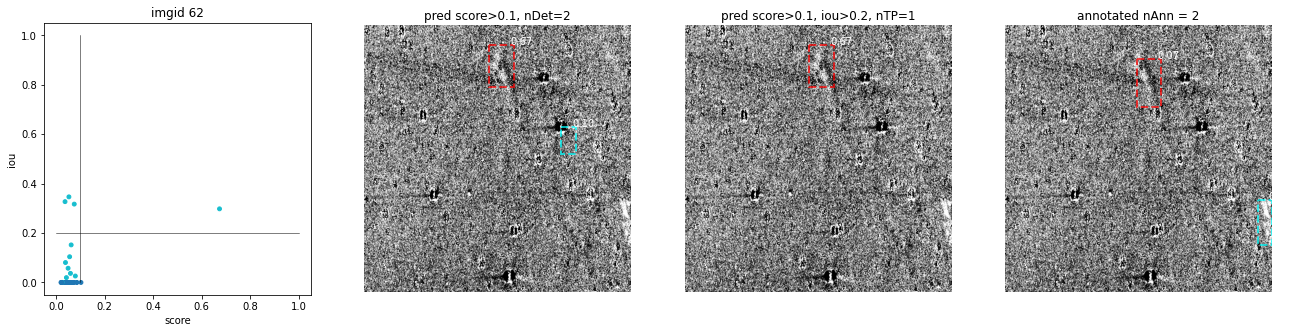

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5) )
df= df_LE_missed.reset_index()
idxes = df['img'].index.to_list()
for idx in idxes:
    df['img'] 
    for ax in axs:
        ax.clear()
    plot_iou_score(df, idx, score_th=0.1, iou_th=0.2, axs=axs)
    fig.savefig("./log_niou/pred_v6_missed_LE/{}".format( df['img'][idx].split('/')[-1] ) )



In [ ]:
np.unique( df['img'] ).shape

(30,)

### visualie layers

In [ ]:
yolo.layers

In [ ]:
layers1 = yolo.layers[1]


In [ ]:
len( layers1.get_weights() )

1

In [ ]:
filters = layers1.get_weights()[0]

In [ ]:
filters.shape

(3, 3, 3, 32)

In [ ]:
from tensorflow.keras.utils import plot_model


In [ ]:
# normalize weights
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
filters.shape[0]

3

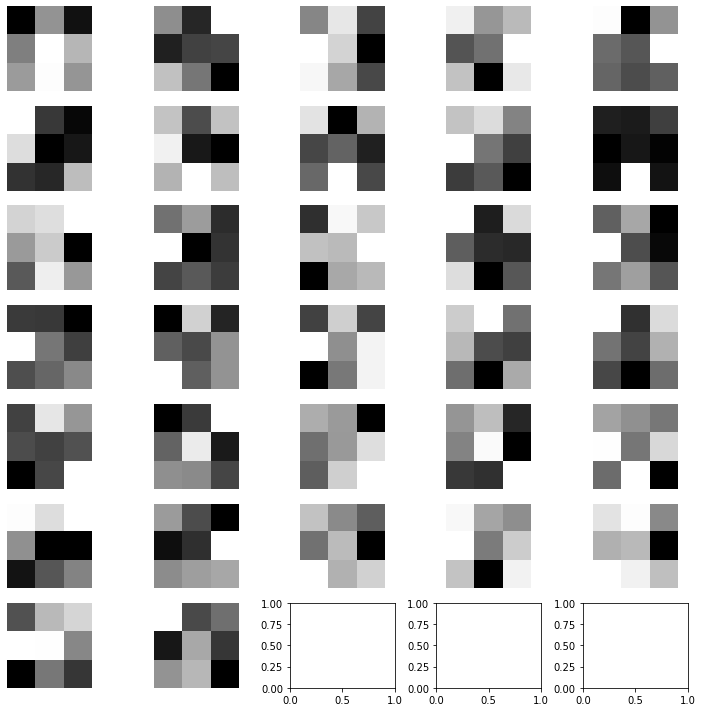

In [ ]:
fig, axs = plt.subplots(7, 5, figsize=(10,10), )
axs = axs.flatten()
for i in range( filters.shape[-1] ):
    ax = axs[i]
    ax.imshow(filters[..., 0, i], cmap='gray')
    ax.axis('off')

fig.tight_layout()

In [ ]:
model = tf.keras.Model(inputs=yolo.inputs, outputs=yolo.layers[1].output)

In [ ]:
imgfiles

In [ ]:
image_path =  './dataset/LEs576aug/tiles_aug/003_5_r180.jpg'
fitspath = image_path.replace("jpg", "fits.npz")
image_data = np.load(fitspath)["fitsarr"]

image_data = tf.expand_dims(image_data, 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


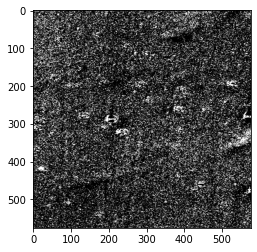

In [ ]:
plt.imshow(image_data[0])

In [ ]:
feature_maps.shape

(1, 576, 576, 32)

In [ ]:
feature_maps = model( image_data ).numpy()
f_min, f_max = np.min(feature_maps, axis=(1,2), keepdims=True), np.max(feature_maps, axis=(1,2), keepdims=True)
feature_maps = (feature_maps - f_min) / (f_max - f_min)


In [ ]:
f_min, f_max

(array([[[[-193.60838 ,  -51.450176,  -71.90347 , -178.5605  ,
           -105.54579 , -132.20593 , -213.46278 ,  -89.386955,
            -73.17824 , -149.82724 , -108.23235 ,  -55.278835,
           -153.70943 , -114.970406,  -77.26012 ,  -46.527233,
            -74.6402  ,  -63.999073,  -77.22514 , -172.42976 ,
           -114.116425, -295.69495 , -221.99306 , -115.28461 ,
           -275.59076 , -291.52948 ,  -87.90795 , -151.1115  ,
            -82.38367 ,  -92.50939 ,  -37.163914, -163.33775 ]]]],
       dtype=float32),
 array([[[[148.77838 , 161.30127 , 216.8883  , 161.27495 ,  88.29831 ,
            73.91688 ,  61.42616 , 288.96158 , 231.87227 , 176.70027 ,
            74.98629 ,  76.796425,  88.390366, 105.72191 , 138.97954 ,
           165.15857 ,  65.50456 , 104.877045, 107.181114,  59.117416,
           109.268074,  78.8629  , 262.75064 ,  39.06719 ,  82.37183 ,
            55.500496, 267.93546 ,  94.82419 , 146.73405 , 172.00162 ,
           132.85562 , 188.43193 ]]]], dtyp

In [ ]:
feature_maps

In [ ]:
yolo.layers

In [ ]:
feature_maps[0, ..., i].min(), feature_maps[0, ..., i].max(), feature_maps[0, ..., i].std(),feature_maps[0, ..., i].mean()

(0.0, 1.0, 0.0029521717, 0.46434903)

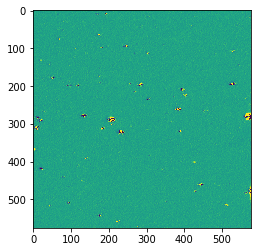

In [ ]:
plt.imshow( feature_maps[0, ..., i], vmin=.462, vmax=0.466, interpolation='nearest' )

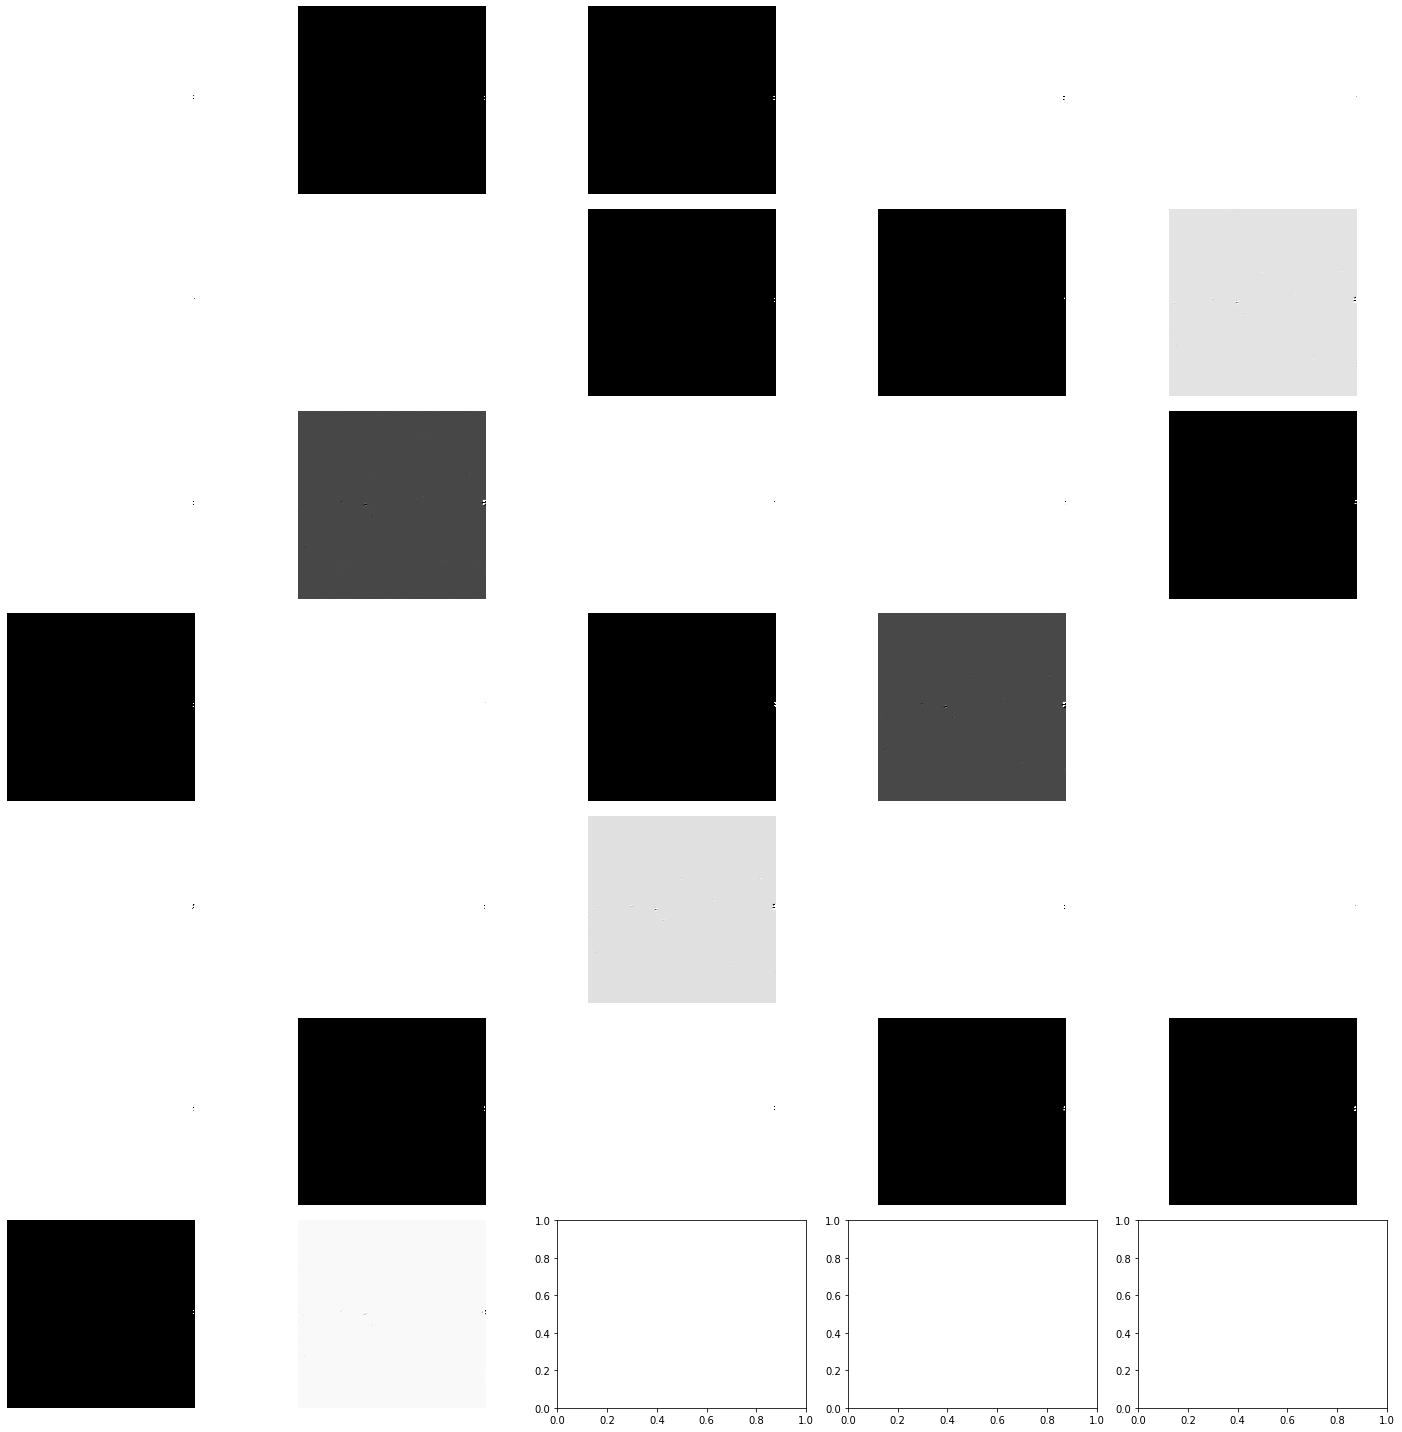

In [ ]:
fig, axs = plt.subplots(7, 5, figsize=(20,20), )
axs = axs.flatten()
for i in range( feature_maps.shape[-1] ):
    ax = axs[i]
    ax.imshow(feature_maps[0, ..., i], vmin=.4,vmax=0.466, cmap='gray')
    ax.axis('off')

fig.tight_layout()

In [ ]:
plot_model(yolo, show_layer_names=True, show_shapes=True, to_file='yolov3_keras.jpg')

### Others

In [ ]:
#df_pred = pd.read_pickle("./log_niou/df_pred_niou_testset.pickle")

In [ ]:
# niou testset
sl = df_pred['img'].str.contains("flip")
df_pred['img'][~sl]

idxes = df_pred['img'][~sl ].index.to_list()
for idx in idxes[::2]:
    plot_iou_score(idx, score_th=0.1, iou_th=0.3)

In [ ]:
# newiou trainset
sl = df_pred['img'].str.contains("r|flip")
df_pred['img'][~sl]

idxes = df_pred['img'][~sl ].index.to_list()
for idx in idxes[::2]:
    plot_iou_score(idx, score_th=0.1, iou_th=0.3)

In [ ]:
# ciou
sl = df_pred['img'].str.contains("r|flip")
df_pred['img'][~sl]

idxes = df_pred['img'][~sl ].index.to_list()
for idx in idxes[::2]:
    plot_iou_score(idx, score_th=0.1, iou_th=0.3)

In [ ]:
# giou
sl = df_pred['img'].str.contains("r|flip")
df_pred['img'][~sl]

idxes = df_pred['img'][~sl ].index.to_list()
for idx in idxes[::2]:
    plot_iou_score(idx, score_th=0.1, iou_th=0.3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
(iou + (N label coners inside predicion) /4 + (N pred coners inside label)/4) /2

In [ ]:
def get_nTP_ann(df_pred, ):
    pass
def get_nTP_ann(df_pred, ):
    pass


0 [134, 126, 119, 105, 85, 66, 50, 31, 17, 1] [2331, 332, 50, 26, 15, 11, 7, 3, 0, 0]
0.1 [134, 126, 119, 105, 85, 66, 50, 31, 17, 1] [2493, 345, 50, 26, 15, 11, 7, 3, 0, 0]
0.2 [134, 126, 119, 105, 85, 66, 50, 31, 17, 1] [2543, 360, 50, 26, 15, 11, 7, 3, 0, 0]
0.3 [128, 121, 114, 102, 82, 64, 48, 31, 17, 1] [2569, 376, 62, 36, 25, 20, 14, 3, 0, 0]
0.4 [102, 101, 99, 95, 78, 61, 46, 29, 15, 1] [2597, 398, 79, 45, 31, 23, 16, 5, 2, 0]
0.5 [65, 65, 64, 60, 49, 37, 29, 15, 4, 0] [2634, 434, 114, 80, 60, 47, 33, 19, 13, 1]
0.6 [37, 37, 36, 32, 29, 20, 19, 10, 2, 0] [2662, 462, 142, 108, 80, 64, 43, 24, 15, 1]
0.7 [17, 17, 17, 17, 17, 15, 15, 7, 2, 0] [2682, 482, 161, 123, 92, 69, 47, 27, 15, 1]
0.8 [5, 5, 5, 5, 5, 5, 5, 3, 0, 0] [2694, 494, 173, 135, 104, 79, 57, 31, 17, 1]


(0.0, 1.0)

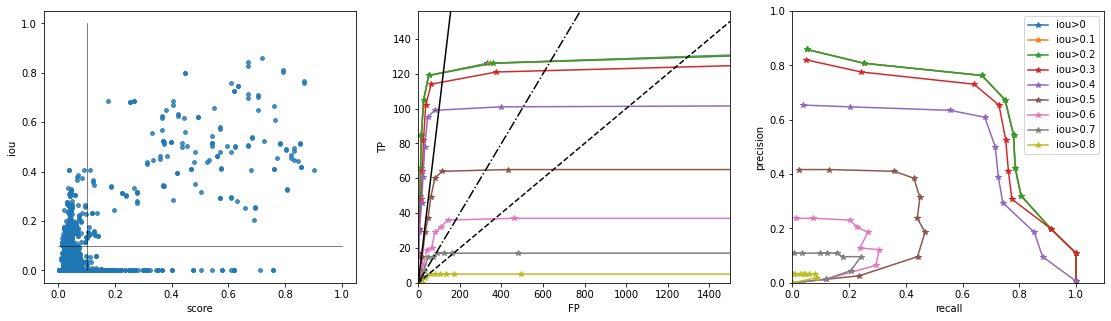

In [ ]:
# niou testset
#df_pred = pd.read_pickle("./log_ciou/df_pred_newiou_testset.pickle")

fig, axs = plt.subplots(1, 3, figsize=(19, 5))
axs = axs.flatten()

IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]
SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]
cls_idx = df_pred['classid']==0
scores_pred = np.concatenate( df_pred[cls_idx] ['score_pred'].values )
ious_pred = np.concatenate( df_pred[cls_idx]['iou_pred'].values )
ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
scores_ann = np.concatenate( df_pred[cls_idx]['score_ann'].values )
ax = axs[0]

ax.scatter(scores_pred, ious_pred, s=15, alpha=0.8, label='')
#ax.scatter(scores_ann, ious_ann, s=10, alpha=0.8, )
ax.plot(np.linspace(0, 1, 10), 0.1*np.ones(10), 'k' , linewidth=0.5)
ax.plot(0.1*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)
ax.set_xlabel("score")
ax.set_ylabel("iou")

ax = axs[1]
ax2 = axs[2]

for iou_th in IOU_THs:
    nTPs = []
    nFPs = []
    precision = []
    recall = []
    for score_th in SCORE_THs:
        # idx_s = scores > score_th
        nDet = np.sum( scores_pred > score_th )
        ious_det_pred = ious_pred [ scores_pred > score_th ]
        ious_det_ann = ious_ann [ scores_ann > score_th ]

        nTP_pred = np.sum( ious_det_pred > iou_th )
        nTP_ann = np.sum( ious_det_ann > iou_th )
        #nTP = np.min([nTP_pred, nTP_ann])
        nFP = nDet - nTP_pred
        nTPs.append(nTP_ann)
        nFPs.append(nFP)

        precision.append(nTP_ann/nDet)
        recall.append(nTP_ann/156)

    print(iou_th, nTPs, nFPs, )
    ax.plot(nFPs, nTPs, '*-', label='iou>{}'.format(iou_th) )
    ax2.plot(precision, recall, '*-', label='iou>{}'.format(iou_th) )

x = np.array(nFPs)
ax.plot(x, x , 'k-', label=' TP/FP = 1', )
ax.plot(x, 1/5 *x , 'k-.', label=' TP/FP = 1/5', )
ax.plot(x, 1/10 *x , 'k--', label=' TP/FP = 1/10', )

#ax.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
#ax.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )

plt.legend(loc='upper right')
ax.set_xlabel("FP")
ax.set_ylabel("TP")
ax.set_xlim([0, 1500])
ax.set_ylim([0, 156])

ax2.set_xlabel("recall")
ax2.set_ylabel("precision")
ax2.set_xlim([0, 1.1])
ax2.set_ylim([0, 1.0])


(0.0, 1.0)

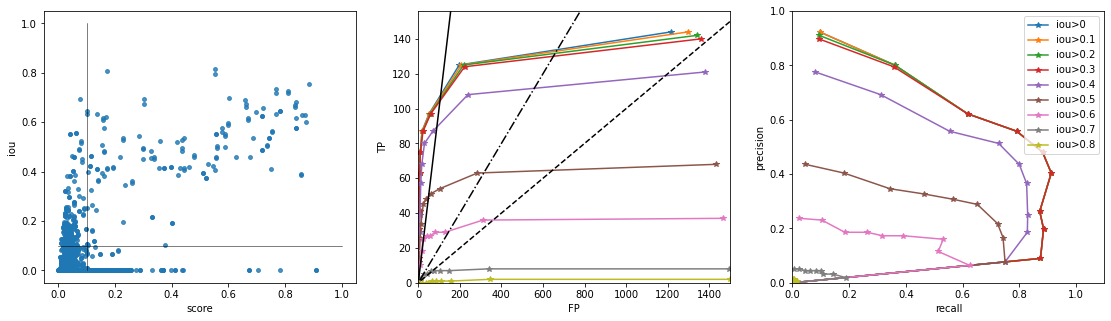

In [ ]:
# diou
df_pred = pd.read_pickle("./log_ciou/df_pred_diou.pickle")

fig, axs = plt.subplots(1, 3, figsize=(19, 5))
axs = axs.flatten()

IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]
SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]
cls_idx = df_pred['classid']==0
scores_pred = np.concatenate( df_pred[cls_idx] ['score_pred'].values )
ious_pred = np.concatenate( df_pred[cls_idx]['iou_pred'].values )
ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
scores_ann = np.concatenate( df_pred[cls_idx]['score_ann'].values )
ax = axs[0]

ax.scatter(scores_pred, ious_pred, s=15, alpha=0.8, label='')
#ax.scatter(scores_ann, ious_ann, s=10, alpha=0.8, )
ax.plot(np.linspace(0, 1, 10), 0.1*np.ones(10), 'k' , linewidth=0.5)
ax.plot(0.1*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)
ax.set_xlabel("score")
ax.set_ylabel("iou")

ax = axs[1]
ax2 = axs[2]

for iou_th in IOU_THs:
    nTPs = []
    nFPs = []
    precision = []
    recall = []
    for score_th in SCORE_THs:
        # idx_s = scores > score_th
        nDet = np.sum( scores_pred > score_th )
        ious_det_pred = ious_pred [ scores_pred > score_th ]
        ious_det_ann = ious_ann [ scores_ann > score_th ]

        nTP_pred = np.sum( ious_det_pred > iou_th )
        nTP_ann = np.sum( ious_det_ann > iou_th )
        #nTP = np.min([nTP_pred, nTP_ann])
        nFP = nDet - nTP_pred
        nTPs.append(nTP_ann)
        nFPs.append(nFP)

        precision.append(nTP_ann/nDet)
        recall.append(nTP_ann/156)
        #print(iou_th, score_th, nDet, len(ious_det), nTP, nFP)
    ax.plot(nFPs, nTPs, '*-', label='iou>{}'.format(iou_th) )
    ax2.plot(precision, recall, '*-', label='iou>{}'.format(iou_th) )

x = np.array(nFPs)
ax.plot(x, x , 'k-', label=' TP/FP = 1', )
ax.plot(x, 1/5 *x , 'k-.', label=' TP/FP = 1/5', )
ax.plot(x, 1/10 *x , 'k--', label=' TP/FP = 1/10', )

#ax.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
#ax.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )

plt.legend(loc='upper right')
ax.set_xlabel("FP")
ax.set_ylabel("TP")
ax.set_xlim([0, 1500])
ax.set_ylim([0, 156])

ax2.set_xlabel("recall")
ax2.set_ylabel("precision")
ax2.set_xlim([0, 1.1])
ax2.set_ylim([0, 1.0])


In [ ]:
while True:
    pass

(0.0, 1.05)

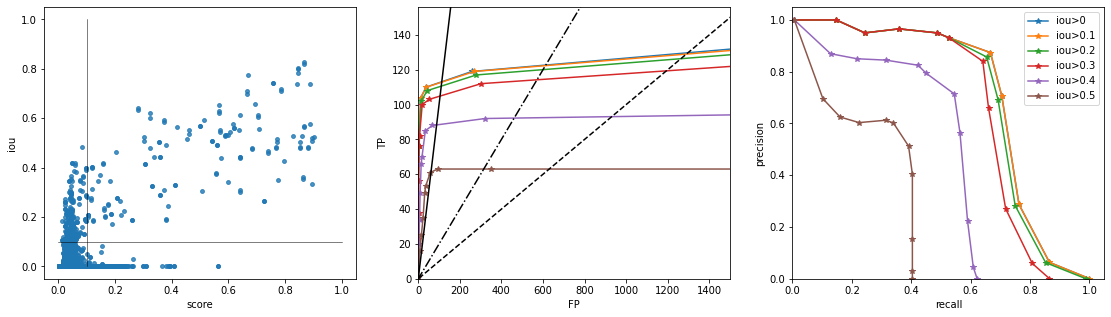

In [ ]:
# ciou
df_pred = pd.read_pickle("./log_ciou/df_pred.pickle")

fig, axs = plt.subplots(1, 3, figsize=(19, 5))
axs = axs.flatten()

IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5,]
SCORE_THs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]
cls_idx = df_pred['classid']==0
scores_pred = np.concatenate( df_pred[cls_idx] ['score_pred'].values )
ious_pred = np.concatenate( df_pred[cls_idx]['iou_pred'].values )
ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
scores_ann = np.concatenate( df_pred[cls_idx]['score_ann'].values )
ax = axs[0]

ax.scatter(scores_pred, ious_pred, s=15, alpha=0.8, label='')
#ax.scatter(scores_ann, ious_ann, s=10, alpha=0.8, )
ax.plot(np.linspace(0, 1, 10), 0.1*np.ones(10), 'k' , linewidth=0.5)
ax.plot(0.1*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)
ax.set_xlabel("score")
ax.set_ylabel("iou")

ax = axs[1]
ax2 = axs[2]

for iou_th in IOU_THs:
    nTPs = []
    nFPs = []
    precision = []
    recall = []
    for score_th in SCORE_THs:
        # idx_s = scores > score_th
        nDet = np.sum( scores_pred > score_th )
        ious_det_pred = ious_pred [ scores_pred > score_th ]
        ious_det_ann = ious_ann [ scores_ann > score_th ]

        nTP_pred = np.sum( ious_det_pred > iou_th )
        nTP_ann = np.sum( ious_det_ann > iou_th )
        #nTP = np.min([nTP_pred, nTP_ann])
        nFP = nDet - nTP_pred
        nTPs.append(nTP_ann)
        nFPs.append(nFP)

        precision.append(nTP_ann/nDet)
        recall.append(nTP_ann/156)
        #print(iou_th, score_th, nDet, len(ious_det), nTP, nFP)
    ax.plot(nFPs, nTPs, '*-', label='iou>{}'.format(iou_th) )
    ax2.plot(recall, precision, '*-', label='iou>{}'.format(iou_th) )

x = np.array(nFPs)
ax.plot(x, x , 'k-', label=' TP/FP = 1', )
ax.plot(x, 1/5 *x , 'k-.', label=' TP/FP = 1/5', )
ax.plot(x, 1/10 *x , 'k--', label=' TP/FP = 1/10', )

#ax.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
#ax.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )

plt.legend(loc='upper right')
ax.set_xlabel("FP")
ax.set_ylabel("TP")
ax.set_xlim([0, 1500])
ax.set_ylim([0, 156])

ax2.set_xlabel("recall")
ax2.set_ylabel("precision")
ax2.set_xlim([0, 1.05])
ax2.set_ylim([0, 1.05])


In [ ]:
df_pred['label_ann']

(0.0, 1.1)

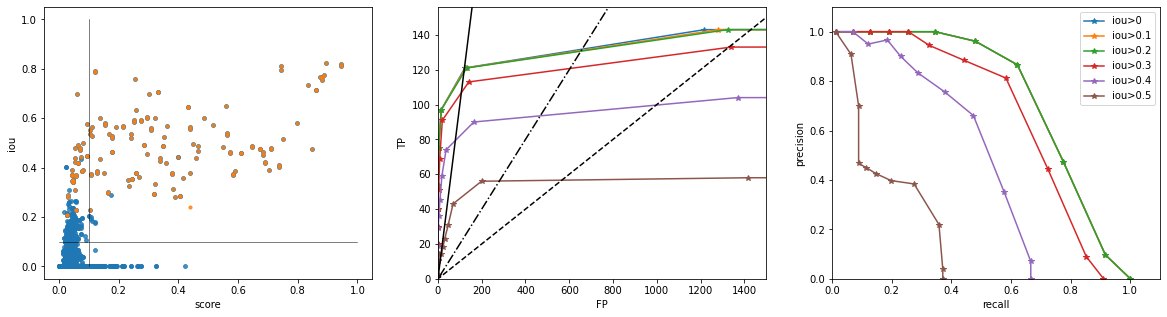

In [ ]:
# giou
df_pred = pd.read_pickle("../LEs_YOLOv3/log/df_pred.pickle")

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs = axs.flatten()

IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5,]
SCORE_THs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]
cls_idx = df_pred['classid']==0
scores_pred = np.concatenate( df_pred[cls_idx] ['score_pred'].values )
ious_pred = np.concatenate( df_pred[cls_idx]['iou_pred'].values )

ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
scores_ann = np.concatenate( df_pred[cls_idx]['score_ann'].values )
nAnn = len(ious_ann)
ax = axs[0]
ax.scatter(scores_pred, ious_pred, s=15, alpha=0.8, label='')
ax.scatter(scores_ann, ious_ann, s=10, alpha=0.8, )
ax.plot(np.linspace(0, 1, 10), 0.1*np.ones(10), 'k' , linewidth=0.5)
ax.plot(0.1*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)
ax.set_xlabel("score")
ax.set_ylabel("iou")

ax = axs[1]
ax2 = axs[2]

for iou_th in IOU_THs:
    nTPs = []
    nFPs = []
    precision = []
    recall = []
    for score_th in SCORE_THs:
        # idx_s = scores > score_th
        nDet = np.sum( scores_pred > score_th )
        ious_det_pred = ious_pred [ scores_pred > score_th ]
        ious_det_ann = ious_ann [ scores_ann > score_th ]

        nTP_pred = np.sum( ious_det_pred > iou_th )
        nTP_ann = np.sum( ious_det_ann > iou_th )
        #nTP = np.min([nTP_pred, nTP_ann])
        nFP = nDet - nTP_pred
        nTPs.append(nTP_ann)
        nFPs.append(nFP)

        precision.append(nTP_ann/nDet)
        recall.append(nTP_ann/nAnn)
        #print(iou_th, score_th, nDet, len(ious_det), nTP, nFP)
    ax.plot(nFPs, nTPs, '*-', label='iou>{}'.format(iou_th) )
    ax2.plot(recall, precision, '*-', label='iou>{}'.format(iou_th) )

x = np.array(nFPs)
ax.plot(x, x , 'k-', label=' TP/FP = 1', )
ax.plot(x, 1/5 *x , 'k-.', label=' TP/FP = 1/5', )
ax.plot(x, 1/10 *x , 'k--', label=' TP/FP = 1/10', )

#ax.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
#ax.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )

plt.legend(loc='upper right')
ax.set_xlabel("FP")
ax.set_ylabel("TP")
ax.set_xlim([0, 1500])
ax.set_ylim([0, nAnn])

ax2.set_xlabel("recall")
ax2.set_ylabel("precision")
ax2.set_xlim([0, 1.1])
ax2.set_ylim([0, 1.1])


Text(0, 0.5, 'TP')

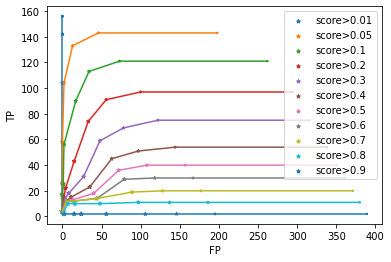

In [ ]:
IOU_THs = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

SCORE_THs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

for score_th in SCORE_THs:
    nTPs = []
    nFPs = []
    for iou_th in IOU_THs:
        # idx_s = scores > score_th
        nDet = np.sum( ious_pred > iou_th )
        scores_det_pred = scores_pred [ ious_pred > iou_th ]
        scores_det_ann = scores_ann [ ious_ann > iou_th ]

        nTP_pred = np.sum( scores_det_pred > score_th )
        nTP_ann = np.sum( scores_det_ann > score_th )
        #nTP = np.min([nTP_pred, nTP_ann])
        nFP = nDet - nTP_pred
        nTPs.append(nTP_ann)
        nFPs.append(nFP)
        #print(iou_th, score_th, nDet, len(ious_det), nTP, nFP)
    plt.plot(nFPs, nTPs, '-', )
    plt.scatter(nFPs, nTPs, marker='*', s=30*np.array(IOU_THs), label='score>{}'.format(score_th) )

plt.legend()
plt.xlabel("FP")
plt.ylabel("TP")


In [ ]:
clsids = [0, 1]

df_iou_score = pd.DataFrame(columns=['img', 'classid',
                                     'boxes_ann', 'label_ann', 'iou_ann',
                                     'boxes_pred', 'label_pred', 'iou_pred', 'score_pred'])

for imgid, image_path in enumerate( imgfiles ):
    # get labeled boxes
    ann = anndic[image_path]
    boxes_ann = ann[:, :4]
    label_ann = ann[:, 4]
    print(imgid, image_path)
    pred = detect_(yolo, image_path=image_path, readfits=True,
                         score_th=0.0001, iou_nms=0.1, showimg=False)
    # pred for one img
    boxes_pred = pred[:, :4]
    score_pred = pred[:, 4]
    label_pred = pred[:, 5]

    iou_pred = get_iou_pred(boxes_pred, label_pred, boxes_ann, label_ann, useiou='iou')
    iou_ann = get_iou_ann(boxes_pred, label_pred, boxes_ann, label_ann, useiou='iou')

    for classid in clsids:

        idxa = label_ann == classid
        idxp = label_pred == classid
        row = {'img':image_path, 'classid': classid, 
           'boxes_ann': boxes_ann[idxa], 'label_ann':label_ann[idxa], 'iou_ann':iou_ann[idxa],
           'boxes_pred': boxes_pred[idxp], 'label_pred': label_pred[idxp], 'iou_pred':iou_pred[idxp], 
           'score_pred': score_pred[idxp]}
        df_iou_score.loc[len(df_iou_score.index)] = row



In [ ]:
np.concatenate ( df_iou_score[ (df_iou_score.classid==0) ] ["boxes_pred"].values ).shape

(203730, 4)

In [ ]:
df_iou_score.columns

Index(['img', 'classid', 'boxes_ann', 'label_ann', 'iou_ann', 'boxes_pred',
       'label_pred', 'iou_pred', 'score_pred'],
      dtype='object')

In [ ]:
df_iou_score[ (df_iou_score.classid==0) ].iloc[9]

img                 ./dataset/LEs576aug/tiles_aug/012_4_r90.jpg
classid                                                       0
boxes_ann     [[239.0, 401.0, 290.0, 505.0], [0.0, 102.0, 28...
label_ann                                            [0.0, 0.0]
iou_ann                [0.598890022058487, 0.36825653157740607]
boxes_pred    [[234.802490234375, 409.85888671875, 297.46630...
label_pred    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
iou_pred      [0.598890022058487, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
score_pred    [0.32184746861457825, 0.13869863748550415, 0.1...
Name: 18, dtype: object

./dataset/LEs576aug/tiles_aug/002_1_flipv.fits.npz


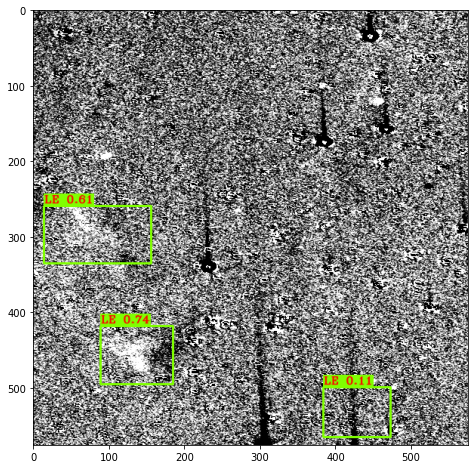

In [ ]:
pred = detect_(yolo, image_path=imgfiles[5], readfits=True,showclassid=0,
                     score_th=0.1, iou_nms=0.1, showimg=True, )


In [ ]:
ious_pred.shape

(203730,)

In [ ]:
# df_iou_score.to_pickle("./log/df_iou_score.pickle")

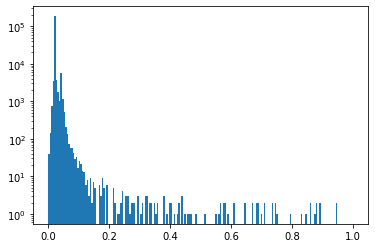

In [ ]:
bins = np.linspace(0, 1, 200)
plt.hist(scores_pred, bins=bins, log=True);
#plt.xlim([0, 0.4])
#plt.ylim([0, 0.4])

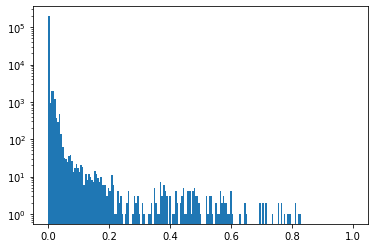

In [ ]:
bins = np.linspace(0, 1, 200)
plt.hist(ious_pred, bins=bins, log=True);
#plt.xlim([0, 0.4])
#plt.ylim([0, 0.4])

(0.0, 1.0)

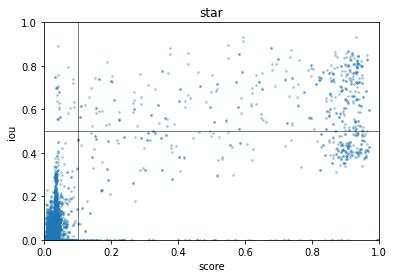

In [ ]:
df = df_iou_score[ (df_iou_score.classid==1) ]
boxes_pred = np.concatenate( df ["boxes_pred"].values )
scores_pred = np.concatenate( df ["score_pred"].values )
ious_pred = np.concatenate( df ["iou_pred"].values )

boxes_ann = np.concatenate( df ["boxes_ann"].values )
ious_ann = np.concatenate( df ["iou_ann"].values )

score_th = 0.1
iou_th = 0.5
x = scores_pred [ scores_pred > 0]
y = ious_pred [ scores_pred > 0]
plt.scatter( x, y, s=3, alpha=0.3)

plt.plot(np.linspace(0, 1, 10), iou_th*np.ones(10), 'k' , linewidth=0.5)
plt.plot(score_th*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)

plt.xlabel("score")
plt.ylabel("iou")
plt.title("star")
plt.xlim([0, 1])
plt.ylim([0, 1])


In [ ]:
ious_ann.shape

(388,)

In [ ]:
IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

for iou_th in IOU_THs:
    nTPs = []
    nFPs = []
    for score_th in SCORE_THs:
        # idx_s = scores > score_th
        nDet = np.sum( scores_pred > score_th )
        ious_det = ious_pred [ scores_pred > score_th ]
        
        nTP = np.sum( ious_det > iou_th )
        nFP = nDet - nTP
        nTPs.append(nTP)
        nFPs.append(nFP)
        print(iou_th, score_th, nDet, len(ious_det), nTP, nFP)
    plt.plot(np.log10(nFPs), nTPs, '*-', label='iou>{}'.format(iou_th) )
plt.legend()
plt.xlabel("FP")
plt.ylabel("TP")


In [ ]:
nTPs

Text(0, 0.5, 'TP')

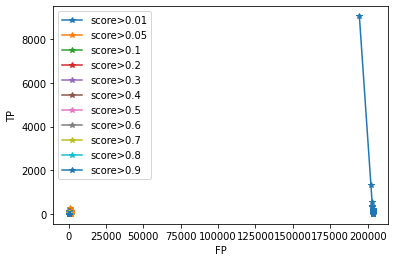

In [ ]:
IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

SCORE_THs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

for score_th in SCORE_THs:
    # idx_s = scores > score_th
    nDet = np.sum( scores_pred > score_th )
    ious_det = ious_pred [ scores_pred > score_th ]

    nTPs = []
    nFPs = []
    for iou_th in np.linspace(0,1,30):#IOU_THs:
        nTP = np.sum( ious_det > iou_th )
        nFP = nDet - nTP
        nTPs.append(nTP)
        nFPs.append(nFP)
        #print(score_th, iou_th, nDet, nTP, nFP, nTP/nFP)
    plt.plot(nFPs, nTPs, '*-', label='score>{}'.format(score_th) )
    #print(nFPs, nTPs)
plt.legend()
plt.xlabel("FP")
plt.ylabel("TP")
#plt.xlim([0, 30])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, 'TP')

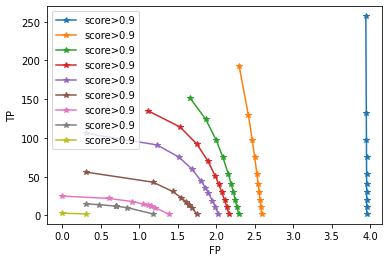

In [ ]:
IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

for iou_th in IOU_THs:
    # idx_s = scores > score_th
    nDet = np.sum( ious_pred > iou_th )
    scores_det = scores_pred [ ious_pred > iou_th ]
    nTPs = []
    nFPs = []
    for score_th in SCORE_THs:
        nTP = np.sum( scores_det > score_th )
        nFP = nDet - nTP
        nTPs.append(nTP)
        nFPs.append(nFP)
        #print(iou_th, score_th, nDet, len(ious_det), nTP, nFP)
    plt.plot(np.log10(nFPs), nTPs, '*-', label='score>{}'.format(score_th) )
plt.legend()
plt.xlabel("FP")
plt.ylabel("TP")


In [ ]:
b = df_iou_score[ (df_iou_score.classid==0) ]['boxes_pred'][0]
s = df_iou_score[ (df_iou_score.classid==0) ]['score_pred'][0]

In [ ]:
while True:
    pass

KeyboardInterrupt: ignored

In [ ]:
for clsid, c in enumerate([0, 1], ['b', 'r']):
    idx = label_pred==clsid
    plt.scatter(x=score_pred[idx], y=iou_pred[idx], marker='*', c=c, alpha=0.8, )
plt.xlabel("score")
plt.ylabel("iou")
plt.legend(labels=['LE', 'star'])

TypeError: ignored

(0.0, 50.0)

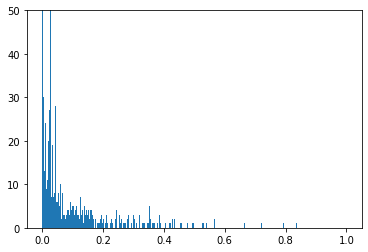

In [ ]:
bins = np.linspace(0, 1, 300)
plt.hist(iou_pred, bins=bins,);
plt.ylim([0, 50])


In [ ]:
pred

In [ ]:
for imgid, image_path in enumerate(imgfiles[:1]):
    
    #image_path = imgfiles[1]
    # get labeled bboxes
    ann = anndic[image_path]
    boxes_ann = ann[:, :4]
    label_ann = ann[:, 4]
    # calculate size for labeled objects
    # get predicted boxes and labels
    pred = detect_(yolo, image_path=image_path, readfits=True,
                     score_th=0.0, iou_nms=0.5, showimg=False)
    


In [ ]:
#anndic = get_annot("dataset/LEs576aug/test_aug1_s_addstar.txt")
#anndic = get_annot("dataset/LEs576aug/train_aug1_s.txt")
anndic = get_annot("dataset/LEs576aug/test_aug1_s.txt")
#anndic = get_annot("dataset/LEs576_new/tiles/LE_test_aug.txt")

#anndic = get_annot("dataset/LEs576aug/test_aug1_s.txt")
#anndic = get_annot("dataset/LEs576_new/tiles/train_augs.txt")
#anndic = get_annot("dataset/LEs576_new/tiles/test_augs.txt")

imgfiles = list( anndic.keys() )

#IOU_THs = [-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]
IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

df_eval = get_df_eval_beta(yolo,imgfiles=imgfiles, SCORE_THs=SCORE_THs, IOU_THs=IOU_THs, CLSIDs=[0, 1], useiou='iou')
df_eval.to_csv("./log/df_eval_testset_beta.csv", index=False)

#df_eval_star = get_df_eval(yolo, SCORE_THs=SCORE_THs, IOU_THs=IOU_THs, CLSID=1, useiou='iou')

#df_eval_star.to_csv("./log/df_eval_star_testset_new.csv", index=False)


In [ ]:
#df_eval.to_pickle("./log/df_eval_testset_beta.pickle")

df_eval = pd.read_csv("./log/df_eval_LE_LE576aug_testset.csv")

In [ ]:
ls 'log'

df_eval_LE_LE576aug_testset.csv
df_eval_LE_LE576aug_trainset.csv
df_eval_LE_LE576new_testset.csv
df_eval_LE_LE576new_trainset.csv
df_eval_LE_testset_new.csv
df_eval_star_LE576aug_testset.csv
df_eval_star_LE576aug_trainset.csv
df_eval_star_LE576new_testset.csv
df_eval_star_LE576new_trainset.csv
df_eval_star_testset_new.csv
df_eval_testset_beta.csv
df_eval_testset_beta.pickle
df_eval_testset.csv
df_eval_testset.pickle
df_loss_new.csv
df_loss_val_new.csv
events.out.tfevents.1615667873.6f6963dd5b7b.58.8885.v2
events.out.tfevents.1615667877.6f6963dd5b7b.58.8893.v2


In [ ]:
#df_eval = pd.read_csv('./log/df_eval_star_test_aug1.csv')
#df_eval = pd.read_csv("./log/df_eval_LE_test_LEs576aug_iou_ep50.csv")
df_eval = pd.read_csv("./log/df_eval_LE_LE576aug_testset.csv")
#df_eval = pd.read_csv("./log/df_eval_LE_LE576new_trainset.csv")

#df_eval = pd.read_csv("./log/df_eval_LE_testAddstar_LEs576aug_iou_ep50.csv")
#df_eval = pd.read_csv("./log/df_eval_star_testset_new.csv")

#df = df_eval.groupby(by=['iou_th', 'score_th']).sum()
#df_eval= pd.read_pickle("./log/df_eval_testset.pickle")


In [ ]:
ls 'log'

In [ ]:
df = df_eval.groupby(by=['iou_th', 'score_th']).sum()
df['nFP'] = df['nDet'] - df['nTP_pred']
df['precision'] = df['nTP_pred'] / df['nDet']
df['recall'] = df['nTP'] / df['nAnn']


In [ ]:
df.head()

nAnn  nDet  nTP_pred  nTP_ann  nTP   nFP  precision    recall
iou_th score_th                                                               
0.0    0.05       156  3883      1129      154  154  2754   0.290755  0.987179
       0.10       156   511       332      136  136   179   0.649706  0.871795
       0.20       156   160       143      109  100    17   0.893750  0.641026
       0.30       156    89        86       82   77     3   0.966292  0.493590
       0.40       156    58        57       55   53     1   0.982759  0.339744

In [ ]:
checkDets = np.concatenate( df['checkDet'].values )
checkDets.shape

(156,)

In [ ]:
boxsizes.shape

(134,)

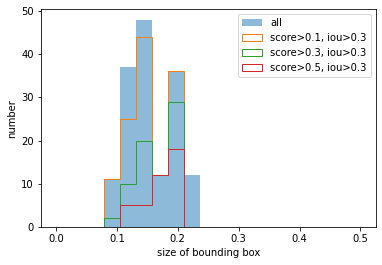

In [ ]:
bins = np.linspace(0, 0.5, 20)

clsid = 0

idx = (df_eval['classid'] == clsid ) & (df_eval['score_th'] == 0.1) & (df_eval['iou_th'] == 0.1)
df = df_eval [ idx ]
boxsizesAll = np.concatenate( df['boxsize'].values )
plt.hist(boxsizesAll, bins=bins, alpha=0.5, label='all', histtype='stepfilled');

for score_th in [0.1, 0.3, 0.5]:
    for iou_th in [0.3,]:
        #score_th = 0.1
        #iou_th = 0.1
        idx = (df_eval['classid'] == clsid ) & (df_eval['score_th'] == score_th) & (df_eval['iou_th'] == iou_th)
        df = df_eval [ idx ]
        checkDets = np.concatenate( df['checkDet'].values )

        boxsizes = boxsizesAll[checkDets]
        label = 'score>{}, iou>{}'.format(score_th, iou_th)
        plt.hist(boxsizes, bins=bins, alpha=1, histtype='step', label=label);

plt.xlabel("size of bounding box")
plt.ylabel("number")
plt.legend()


In [ ]:
while True:
    pass

KeyboardInterrupt: ignored

In [ ]:
df['boxsize'].values

In [ ]:
boxsizes = np.concatenate( df['boxsize'].values )
checkDets = np.concatenate( df['checkDet'].values )


In [ ]:
df_eval['iou_th'].unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [ ]:
df

In [ ]:
plt.figure(figsize=(8, 6))
clsid = 0
IOU_THs = [ 0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

for iou in IOU_THs:
    #x = df.loc[clsid, iou, :].recall.values
    #y = df.loc[clsid, iou, :].precision.values
    for score in 

plt.xlim([0,1.1])
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('LE test')
#plt.ylim([0, 0.3])

SyntaxError: ignored

In [ ]:
y.shape

(9,)

In [ ]:
plt.figure(figsize=(8, 6))
clsid = 1
IOU_THs = [ 0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

for score in SCORE_THs:
    x = df.loc[clsid, :, score].recall.values
    y = df.loc[clsid, :, score].precision.values
    
    plt.plot(x, y, '-', label='score>{}'.format(score), )
    plt.scatter(x, y, s=np.array(IOU_THs)*30, marker='x' )

plt.xlim([0,1.1])
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('LE test')
#plt.ylim([0, 0.3])

In [ ]:
df.head()

nAnn  nDet  nTP_pred  nTP_ann  nTP   nFP  precision    recall
iou_th score_th                                                               
0.0    0.05       156  3883      1129      154  154  2754   0.290755  0.987179
       0.10       156   511       332      136  136   179   0.649706  0.871795
       0.20       156   160       143      109  100    17   0.893750  0.641026
       0.30       156    89        86       82   77     3   0.966292  0.493590
       0.40       156    58        57       55   53     1   0.982759  0.339744

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0.5, 1.0, 'LE test')

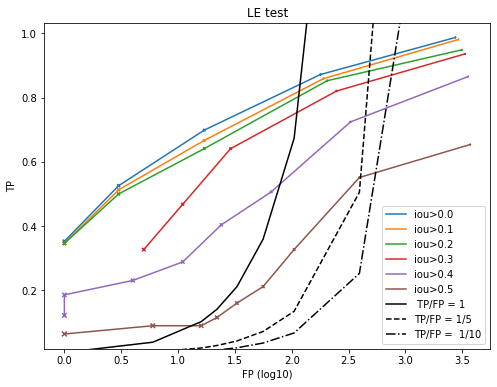

In [ ]:
plt.figure(figsize=(8, 6))
#IOU_THs = [ 0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

IOU_THs = [ 0., 0.1, 0.2, 0.3, 0.4, 0.5, ]
#SCORE_THs = [0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]

for iou in IOU_THs:
    x = np.log10( df.loc[iou, :].nFP.values )
    #x =  df.loc[iou, :].nFP.values 

    y = df.loc[iou, :].nTP_ann.values / 156
    
    plt.plot(x, y, '-', label='iou>{}'.format(iou), )
    plt.scatter(x, y, s=np.array(SCORE_THs)*30, marker='x' )

xlim = plt.xlim()
ylim = plt.ylim()

plt.plot(x,  df.loc[iou, :].nFP.values / 156, 'k-', label=' TP/FP = 1'.format(iou), )
plt.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
plt.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend(loc="best")
plt.xlabel('FP (log10)')
plt.ylabel('TP')
plt.title('LE test')
#plt.xlim([0, 400])
#plt.ylim([0, 400])

In [ ]:
ylim

(-15.0, 315.0)

Text(0.5, 1.0, 'LE testset')

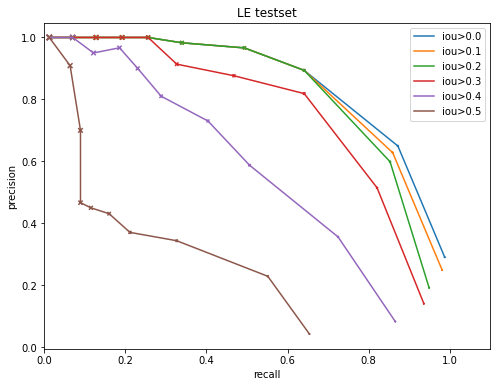

In [ ]:
# LE test
plt.figure(figsize=(8, 6))
for iou in IOU_THs:
    x = df.loc[iou, :].recall.values
    y = df.loc[iou, :].precision.values
    
    plt.plot(x, y, '-', label='iou>{}'.format(iou))
    plt.scatter(x, y, s=np.array(SCORE_THs)*30, marker='x' )

plt.xlim([0,1.1])
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('LE testset')

Text(0.5, 1.0, 'star testset')

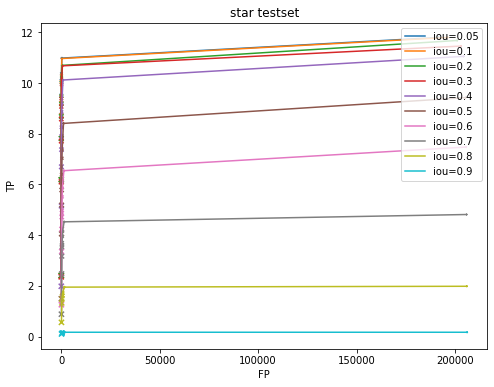

In [ ]:
# roc star train
plt.figure(figsize=(8, 6))
for iou in IOU_THs:
    x = df.loc[iou, :].nFP 
    y = df.loc[iou, :].nTP / 59
    plt.plot(x, y, '-', label='iou={}'.format(iou))

    plt.scatter(x, y, s=np.array(SCORE_THs)*30, marker='x', label=None)
    
plt.legend(loc='upper right')

#plt.ylim([0,1])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('star testset')

In [ ]:
df.head()

Text(0.5, 1.0, 'LE testset')

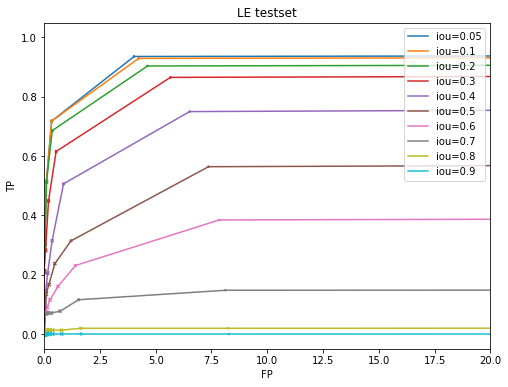

In [ ]:
# roc LE train
plt.figure(figsize=(8, 6))
for iou in IOU_THs:
    x = df.loc[iou, :].nFP 
    y = df.loc[iou, :].nTP / 156
    plt.plot(x, y, '-', label='iou={}'.format(iou))

    plt.scatter(x, y, s=np.array(SCORE_THs)*30, marker='x', label=None)
    
plt.legend(loc='upper right')

#plt.ylim([0,1])
#plt.xlim([0, 20])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('LE testset')

#### plot detected boxes

In [ ]:
anntxt = "dataset/LEs576_new/tiles/test_augs.txt"

anndic = get_annot(anntxt)
imgfiles = list( anndic.keys() )

In [ ]:
CLSID = 0
IOU_TH = 0.1

In [ ]:
# get labeled bboxes
SCORE_TH = 0.2
image_path = imgfiles[10]
ann = anndic[image_path]
boxes_ann = ann[:, :4]
label_ann = ann[:, 4]

# get predicted boxes and labels
pred = detect_(yolo, image_path=image_path, readfits=True,
                 score_th=SCORE_TH, iou_nms=0.5, showimg=False)

boxes_pred = pred[:, :4]
score_pred = pred[:, 4]
label_pred = pred[:, 5]

iou_ann = get_iou_ann(boxes_pred, label_pred, boxes_ann, label_ann)

iou_pred = get_iou_pred(boxes_pred, label_pred, boxes_ann, label_ann)

classid = CLSID

boxes_ann_cls = boxes_ann [label_ann==classid]
boxes_pred_cls = boxes_pred [label_pred==classid]

iou_ann_cls = iou_ann [label_ann==classid]
iou_pred_cls = iou_pred [label_pred==classid]

score_pred_cls = score_pred[label_pred==classid]

nAnn = len(boxes_ann_cls)
nDet = len(boxes_pred_cls)
nTP_pred = np.sum(iou_pred_cls > IOU_TH)
nTP_ann = np.sum(iou_ann_cls > IOU_TH)
nTP = min([nTP_pred, nTP_ann])

./dataset/LEs576_new/tiles/LE_aug/006_7_fliph.fits.npz


In [ ]:
len(boxes_pred_cls)

12

In [ ]:
IOU_TH

0.1

In [ ]:
iou_ann_cls

array([0.94741   , 0.96428632])

Text(0.5, 0.98, '006_7_fliph.jpg score>0.2')

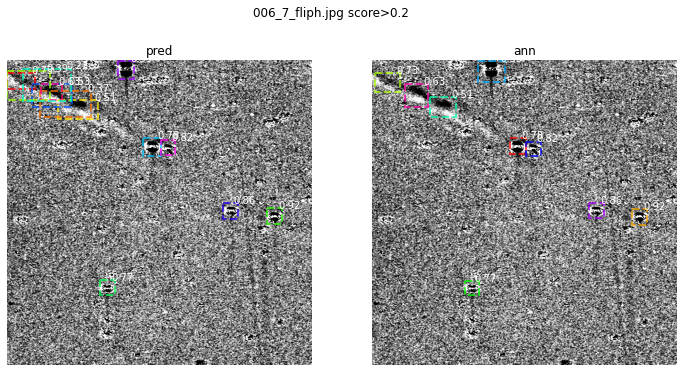

In [ ]:
img = cv2.imread(image_path)
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

plot_bboxes(img, bboxes=boxes_pred, labels=iou_pred, ax=axs[0], title='pred')
plot_bboxes(img, bboxes=boxes_ann, labels=iou_ann, ax=axs[1], title='ann')
axs[0].axis('off')
axs[1].axis('off')

suptitle = '{} score>{}'.format( os.path.basename(image_path), SCORE_TH)
plt.suptitle(suptitle)

#fig.savefig('./results/{}.pdf'.format(suptitle))

In [ ]:
while True:
    pass

KeyboardInterrupt: ignored

In [ ]:
score_pred_cls

array([0.27517158, 0.26561224, 0.25481141, 0.24963905, 0.2481799 ,
       0.15343614, 0.13319042, 0.12133232, 0.12055738, 0.10987054,
       0.10900336, 0.10827558, 0.10731409, 0.10630008, 0.1033214 ,
       0.10253913, 0.10005161])

In [ ]:
iou_pred_cls

array([0.98637138, 0.82058117, 0.97973128, 0.47012683, 0.28534831,
       0.25843967, 0.        , 0.        , 0.49531883])

In [ ]:
df_loss = pd.read_csv('./log/df_loss_new.csv')
df_loss_val = pd.read_csv('./log/df_loss_val_new.csv')


(0.0, 500.0)

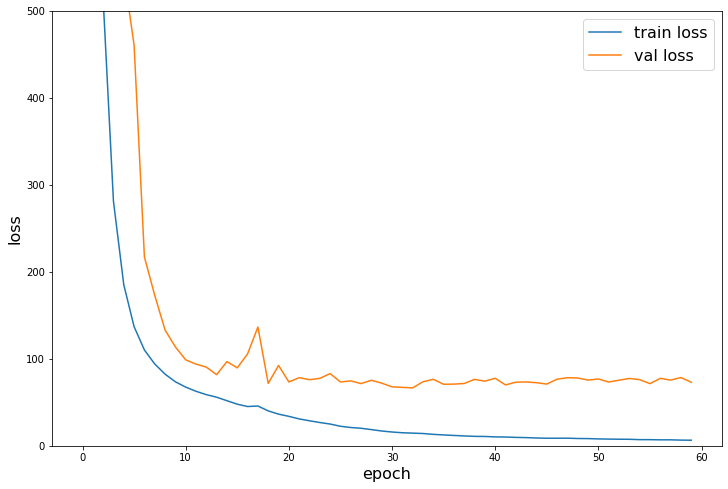

In [ ]:
#x = df_loss['epoch'].values
x = df_loss.index.to_list() 
y1 = df_loss['total_loss'].values  
y2 = df_loss_val['total_val_loss'].values 

plt.figure(figsize=(12,8))
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='val loss')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend(fontsize=16)

#plt.xlim([300, 400])
plt.ylim([0, 500])